## Setup - imports, time, parameters, size function

In [1]:
runno = '7481'

In [2]:
from invisible_cities.database import load_db

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sys import getsizeof

In [4]:
import sys

def get_size(obj, seen=None,):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [5]:
from time import time as time
t0 = time()

In [6]:
# Fit functions

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def gauss2(x, A, m, v): 
    if v <= 0:
        return 1e10
    return A*np.exp(-(x-m)**2 / (2*v))

def offset_gauss(x, A, m, v, C):
    return C + A*np.exp(-(x-m)**2 / (2*v))

def const(x, a):
    return a + 0*x

def line(x, m, b):
    return m*x + b

from scipy.optimize import curve_fit

def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

## HIGH STATISTICS COMBINED FILE READING

In [7]:
f = open('/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20201222/meshed_output_allfiles_'+runno+'.json')
histat_data = json.load(f)
f.close()

In [8]:
histat_data.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres'])

In [9]:
len(histat_data['events_energy'])

691639

In [10]:
histat_events_energy_subtracted_pre = np.array(histat_data['events_energy']) - np.array(histat_data['events_prewindow_sums'])
histat_events_energy_subtracted_post = np.array(histat_data['events_energy']) - np.array(histat_data['events_postwindow_sums'])
histat_prepostavg = np.array(histat_data['events_postwindow_sums']) / 2 + np.array(histat_data['events_postwindow_sums']) / 2
histat_events_energy_subtracted_avg = np.array(histat_data['events_energy']) - histat_prepostavg

histat_Zgauss = np.array(histat_data['all_Zgauss'])
histat_Zrms = np.array(histat_data['all_Zrms'])
histatX, histatY = np.array(histat_data['events_X_sipm_subtracted']), np.array(histat_data['events_Y_sipm_subtracted'])
histatR2 = np.array(histat_data['all_R2'])
histatSRES = np.array(histat_data['all_sres'])
histatSSRES = np.array(histat_data['all_ssres'])

In [11]:
import itertools as it
zlims = [100, 200, 300, 400, 510]
rlims = [50, 100, 150, 180]
nomask = np.ones(len(histatR2), dtype='bool')

def get_bin_from_xy(x, y, emap, bounds):
    lowerx, lowery = bounds[0][0], bounds[1][0]
    upperx, uppery = bounds[0][1], bounds[1][1]
    nbinsx = len(emap)
    nbinsy = len(emap[0])
    dbinx = (bounds[0][1] - bounds[0][0]) / nbinsx
    dbiny = (bounds[1][1] - bounds[1][0]) / nbinsy
    ix = min(floor((x - lowerx) / dbinx), nbinsx-1)
    iy = min(floor((y - lowery) / dbiny), nbinsy-1)
    return ix, iy

def correct_energies(emap, bounds, umask = nomask, ltmap = None, show = True, xvals = histatX, yvals = histatY, energies = histat_events_energy_subtracted_pre, vocal = False):
    if vocal:
        print('Correcting energies...')
    ecorrs = []
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    tcorstart = time()
    masked_xvals, masked_yvals = xvals[umask & xymask], yvals[umask & xymask]
    masked_energies = energies[umask & xymask]
    ncorevents = len(masked_xvals)
    factor_default = emap[int(len(emap)/2)][int(len(emap)/2)]
    for e in range(ncorevents):
        if vocal and e % 100000 == 0:
            print(e, '/', len(xvals[umask & xymask]))
            if e > 0:
                print('Est remaining =', round((ncorevents - e)*(time() - tcorstart) / e, 1))
        x, y = masked_xvals[e], masked_yvals[e]
        ix, iy = get_bin_from_xy(x, y, emap, bounds)
        factor = emap[ix][iy]
        if factor == 0 or np.isnan(factor):
            factor = factor_default
        if ltmap is not None:
            ixlt, iylt = get_bin_from_xy(x, y, ltmap, bounds)
            lt = ltmap[ixlt][iylt]
            z = all_Zgauss[umask & xymask][e]
            ltcorr = np.exp(z / lt)
            factor /= ltcorr
        ecorr = masked_energies[e] / factor
        ecorrs.append(ecorr)
    if show:
        plt.hist(ecorrs)
        plt.show()
    return np.array(ecorrs)

def fit_res_vs_zr(energies, emap, bounds, umask = nomask, show = True, xvals = histatX, yvals = histatY, zvals = histat_Zgauss):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        h = plt.hist(energies[fidmask], range=(0.85, 1.15), bins = 30)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), 1, np.std(energies[fidmask]))
        
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if zlim == zlims[0] and rlim == rlims[0] and show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_zr

def plot_res_vs_zr(res_vs_zr):
    for rlim in rlims:
        res_vs_z = [ res_vs_zr[1000*zlim + rlim] for zlim in zlims ]
        plt.plot(zlims, res_vs_z, 'o', label = 'rlim = '+str(rlim)+' mm')
    plt.legend()
    plt.xlabel('Z upper limit (mm)')
    plt.ylabel('Resolution (%)')
    plt.show()
    print('Innermost resolution = ', round(res_vs_zr[1000*zlims[0] + rlims[0]], 2), '%')
    print('Outermost resolution = ', round(res_vs_zr[1000*zlims[-1] + rlims[-1]], 2), '%')
    
import h5py

def load_maps_from_file(filename, show = True):
    f = h5py.File(filename, 'r')
    e0map = np.array(f['e0']['block0_values'])
    ltmap = np.array(f['lt']['block0_values'])
    # f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]
    bounds = ((f['mapinfo']['values'][0], f['mapinfo']['values'][1]), (f['mapinfo']['values'][2], f['mapinfo']['values'][3]))
    f.close()

    if show:
        plt.imshow(e0map, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('E0')
        plt.show()

        plt.imshow(ltmap, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('LT')
        plt.clim(5000, 10000)
        plt.show()
    
    return e0map, ltmap, bounds

## Determine the range of the peak

### R2, SRES, SSRES distributions

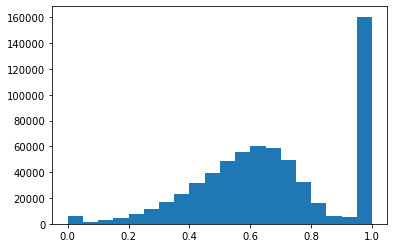

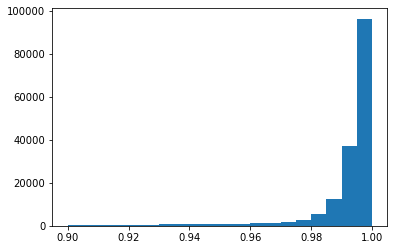

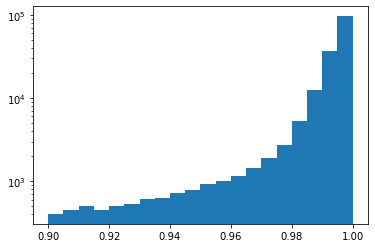

In [12]:
plt.hist(histatR2, range=(0, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.yscale('log')
plt.show()

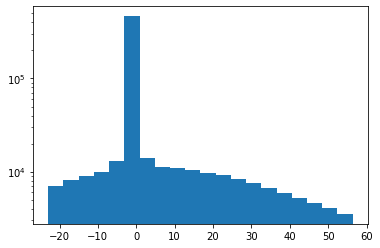

In [13]:
plt.hist(histatSRES, range=(np.percentile( histatSRES, 5), np.percentile( histatSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

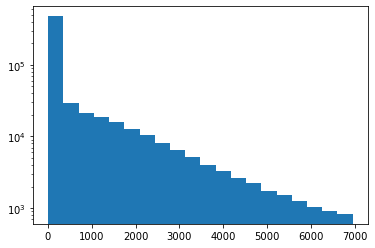

In [14]:
plt.hist(histatSSRES, range=(np.percentile( histatSSRES, 5), np.percentile( histatSSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

In [15]:
# Constant cuts
noise_bound = 0
zmax = 510
hienergybound = 2 # Events with double the median energy are excluded as possible Kr events

In [16]:
# Choose your analysis parameters:
# histat_events_energy_subtracted = histat_events_energy_subtracted_pre
# r2cut = 0.98
# histatZ = histat_Zgauss

## Check XYZ distributions

Peak range = 467.3 , 3365.5
Selected percentage = 10.9 %


/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide


Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 6.2
200000 / 584720
Est remaining = 4.9
300000 / 584720
Est remaining = 3.6
400000 / 584720
Est remaining = 2.4
500000 / 584720
Est remaining = 1.1


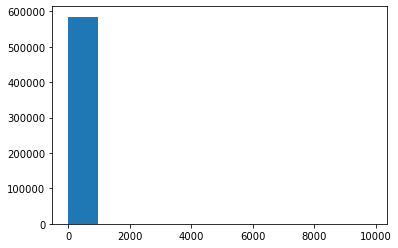

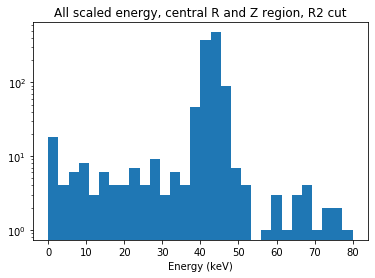

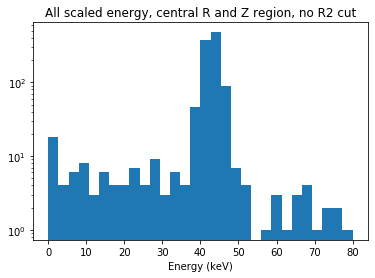

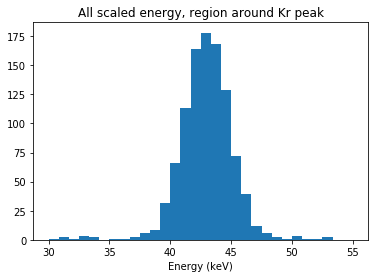

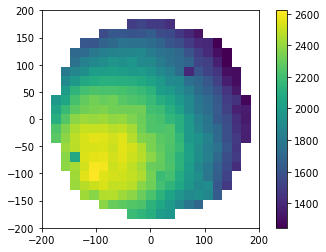

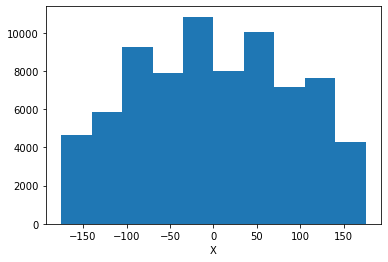

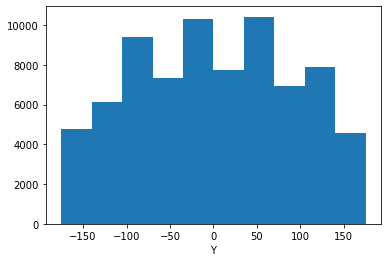

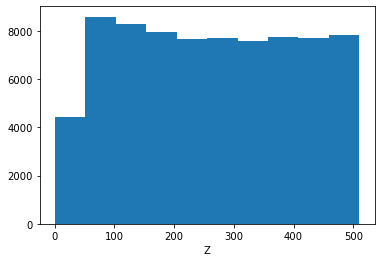

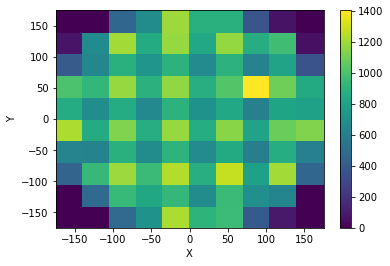

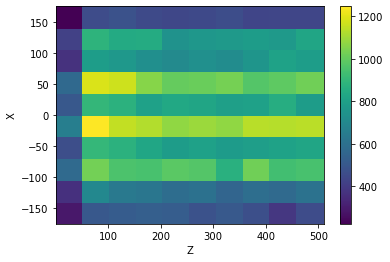

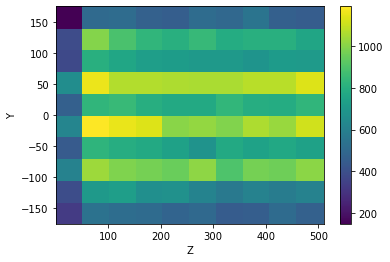

In [17]:
r2cut = 0.9
histatZ = histat_Zgauss
r2mask = histatR2 > r2cut
zmask = (histatZ > 0) & (histatZ < zmax)
rmask = histatX**2 + histatY**2 < 180**2
r2ZRnoisemask = r2mask & zmask & rmask # & (histat_events_energy_subtracted_pre > noise_bound)
hienergymask = histat_events_energy_subtracted_pre < hienergybound * np.percentile(histat_events_energy_subtracted_pre[r2ZRnoisemask], 50)
r2ZRhinoisemask = r2ZRnoisemask & hienergymask

med = np.median(histat_events_energy_subtracted_pre[r2ZRhinoisemask])
frac = 0.6827
lowcut = 0.5 - frac / 2
hicut = 0.5 + frac / 2
lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * lowcut))
rgt = med + 3 * (np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * hicut) - med)
print('Peak range =', round(lft,1),',', round(rgt,1))
histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted_pre > lft) & (histat_events_energy_subtracted_pre < rgt)
print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '%')

# Create own correction map
nbins = 23
clim = 200
dbin = 2 * clim / nbins
coord_range = np.linspace(-clim, clim, nbins + 1)
coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
events_sum = np.zeros((len(coord_bins),len(coord_bins)))
for ix in range(len(coord_bins)):
    for iy in range(len(coord_bins)):
        xbin = coord_bins[ix]
        ybin = coord_bins[iy]
        xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
        ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
        xymask = xmask & ymask
        events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
        energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted_pre[xymask & histat_selfmask])

energy_xy = energy_sum / events_sum
energy_xy_bounds = ((-200, 200), (-200, 200))

# Apply the correction
histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted_pre, xvals = histatX, yvals = histatY, vocal = True)
histat_all_scaled_energy *= 41.5



# Final cut spectra
histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, no R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
plt.title('All scaled energy, region around Kr peak')
plt.xlabel('Energy (keV)')
plt.show()


plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
plt.colorbar()
plt.show()


plt.hist(histatX[histat_selfmask])
plt.xlabel('X')
plt.show()

plt.hist(histatY[histat_selfmask])
plt.xlabel('Y')
plt.show()

plt.hist(histatZ[histat_selfmask])
plt.xlabel('Z')
plt.show()

h = plt.hist2d(histatX[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatX[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('X')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

In [18]:
def check_resolution(histatZ, histat_events_energy_subtracted, r2cut):

    # Create masks
    r2mask = histatR2 > r2cut
    zmask = (histatZ > 0) & (histatZ < zmax)
    rmask = histatX**2 + histatY**2 < 180**2
    r2ZRnoisemask = r2mask & (histat_events_energy_subtracted > noise_bound) & zmask & rmask
    hienergymask = histat_events_energy_subtracted < hienergybound * np.percentile(histat_events_energy_subtracted[r2ZRnoisemask], 50)
    r2ZRhinoisemask = r2ZRnoisemask & hienergymask

    # Set peak range
    med = np.median(histat_events_energy_subtracted[r2ZRhinoisemask])
    frac = 0.6827
    lowcut = 0.5 - frac / 2
    hicut = 0.5 + frac / 2
    lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * lowcut))
    rgt = med + 3 * (np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * hicut) - med)
    print('Peak range =', round(lft,1),',', round(rgt,1))
    histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted > lft) & (histat_events_energy_subtracted < rgt)
    print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '\%')
    
    # Plot spectra after applying various cuts
    plt.hist(histat_events_energy_subtracted, bins = 25)
    plt.yscale('log')
    plt.title('Full spectrum')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted, range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(lft, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[histat_selfmask], bins = 25)
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut; linear scale')
    plt.xlabel('Energy (pes)')
    plt.show()

    # Noise spectrum
    plt.hist(histat_events_energy_subtracted, range=(0, 500), bins = 25)
    plt.title('Noise spectrum')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_events_energy_subtracted[~r2mask], range=(0, 500), bins = 25)
    plt.title('Noise spectrum, bad R2')
    plt.yscale('log')
    plt.show()

    # Create own correction map
    nbins = 23
    clim = 200
    dbin = 2 * clim / nbins
    coord_range = np.linspace(-clim, clim, nbins + 1)
    coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

    energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
    events_sum = np.zeros((len(coord_bins),len(coord_bins)))
    for ix in range(len(coord_bins)):
        for iy in range(len(coord_bins)):
            xbin = coord_bins[ix]
            ybin = coord_bins[iy]
            xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
            ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
            xymask = xmask & ymask
            events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
            energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted[xymask & histat_selfmask])

    energy_xy = energy_sum / events_sum
    energy_xy_bounds = ((-200, 200), (-200, 200))

    plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    map_out = './maps_from_maxsipm/map_'+runno+'.npy'

    with open(map_out, 'wb') as f:
        np.save(f, energy_xy)

    with open(map_out, 'rb') as f:
        test_readin_xy = np.load(f)

    plt.imshow(test_readin_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    # Apply the correction
    histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
    histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)
    histat_all_scaled_energy *= 41.5

    plt.hist(histat_all_scaled_energy, range = (0, 80), bins = 20)
    plt.title('All scaled energy')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    # Final cut spectra
    histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, no R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
    plt.title('All scaled energy, region around Kr peak, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.show()

    # r7472_scaled_energy = correct_energies(e0_7472, bounds_7472, umask = selfmask, ltmap = lt_7472)
    # r7472_res_vs_zr = fit_res_vs_zr(r7472_scaled_energy, e0_7472, bounds_7472, umask = selfmask)
    histat_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_selfmask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)

    histat_self_res_vs_zr = fit_res_vs_zr(histat_scaled_energy, energy_xy, energy_xy_bounds, umask = histat_selfmask, xvals = histatX, yvals = histatY, zvals = histatZ)
    plot_res_vs_zr(histat_self_res_vs_zr)
    print('All resolutions:', histat_self_res_vs_zr)
    
    return histat_self_res_vs_zr


================ CHECKING R2 CUT = 0.4 ================
Peak range = 189.6 , 3408.0
Selected percentage = 11.2 \%


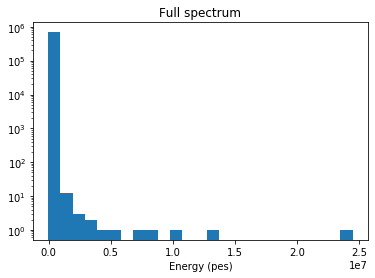

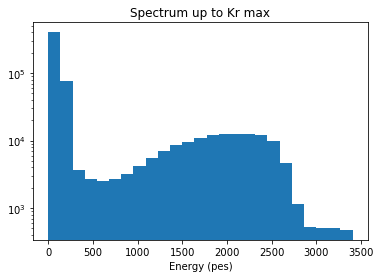

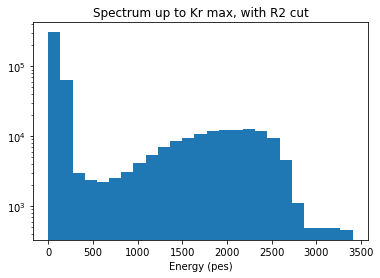

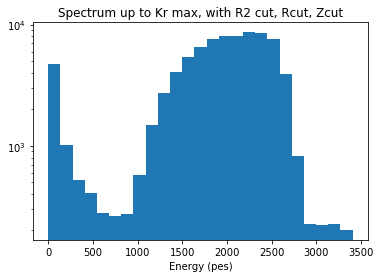

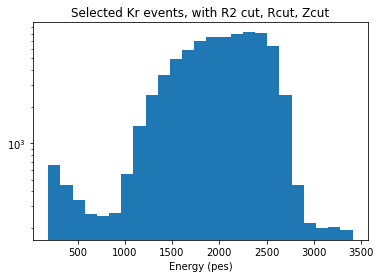

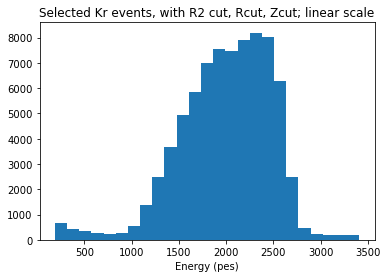

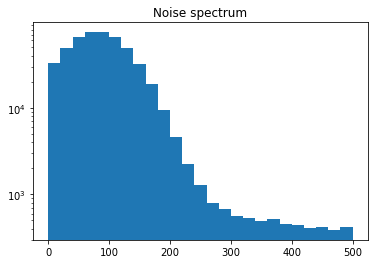

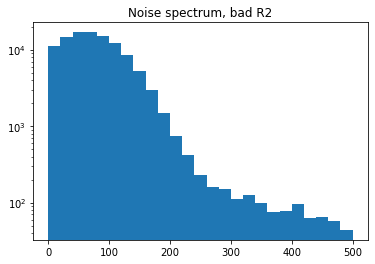

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


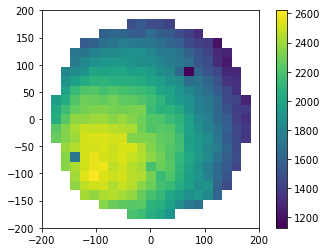

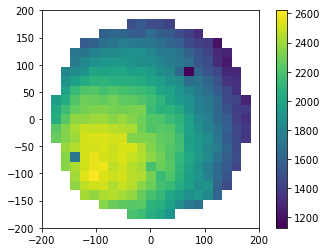

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 7.7
200000 / 584720
Est remaining = 5.5
300000 / 584720
Est remaining = 3.9
400000 / 584720
Est remaining = 2.6
500000 / 584720
Est remaining = 1.2


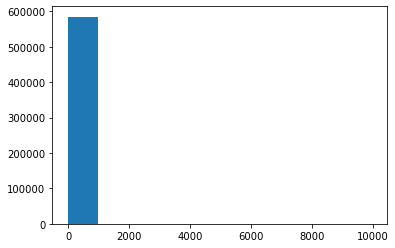

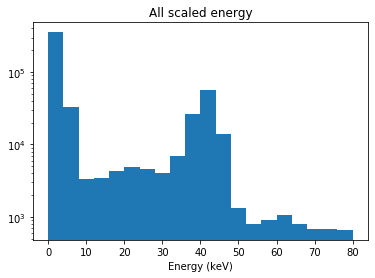

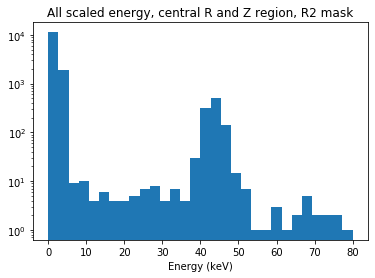

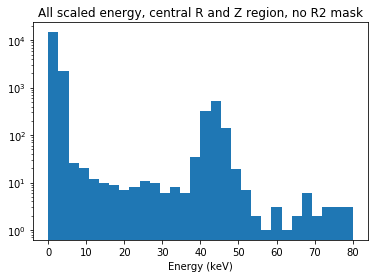

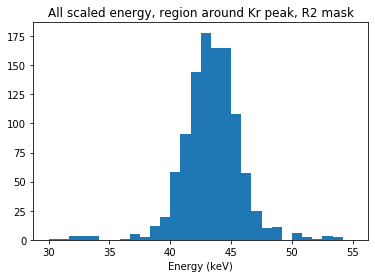

Correcting energies...
0 / 77293


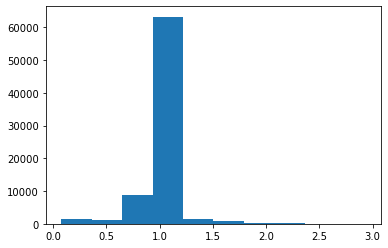

Fit a Gaussian with guess (A0, m0, s0) = (90.0, 1, 0.14666317451345753)


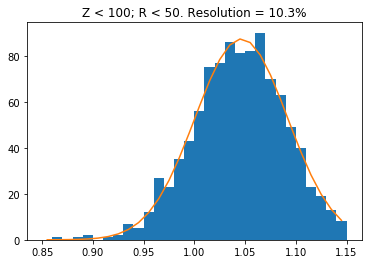

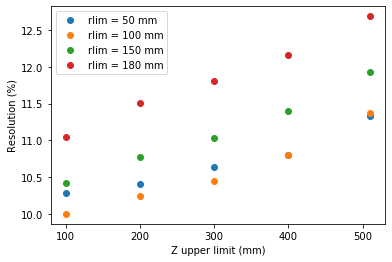

Innermost resolution =  10.28 %
Outermost resolution =  12.69 %
All resolutions: {100050: 10.280482903618356, 100100: 9.997366180673126, 100150: 10.421527783749536, 100180: 11.04690293289376, 200050: 10.404903702445795, 200100: 10.244378067377989, 200150: 10.773270718766648, 200180: 11.502929467943614, 300050: 10.632273937466575, 300100: 10.446618003430176, 300150: 11.026049029936308, 300180: 11.808441689473776, 400050: 10.800619554730176, 400100: 10.79449651247719, 400150: 11.400379654466594, 400180: 12.160762648788353, 510050: 11.335688815872897, 510100: 11.371662716048231, 510150: 11.934911262412902, 510180: 12.691169057677754}

================ CHECKING R2 CUT = 0.5 ================
Peak range = 224.9 , 3403.4
Selected percentage = 11.1 \%


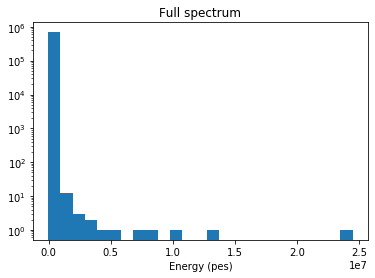

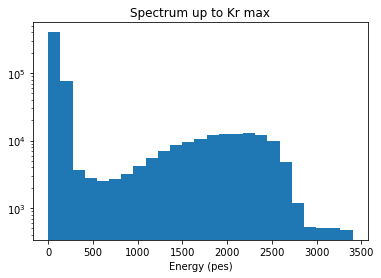

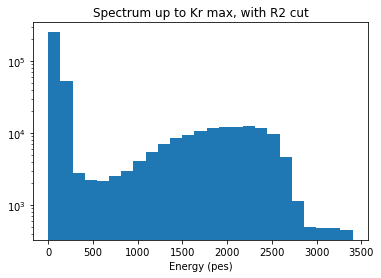

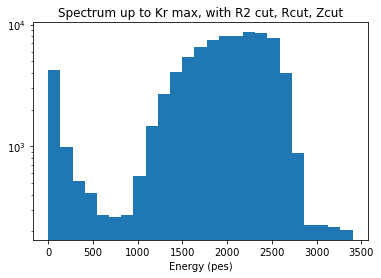

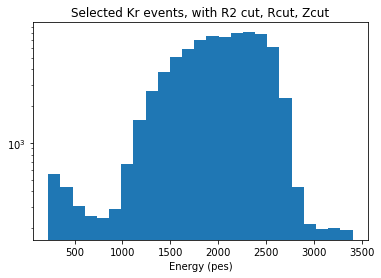

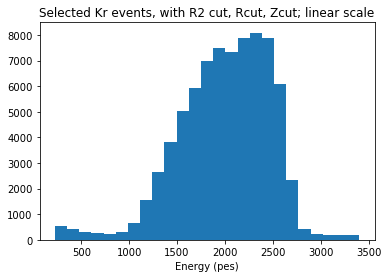

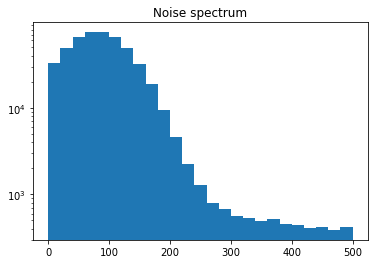

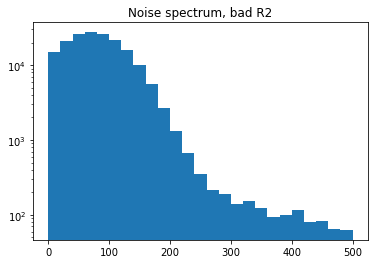

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


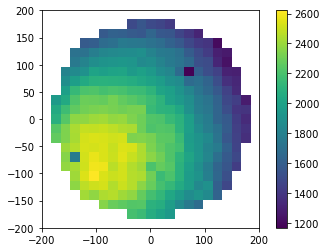

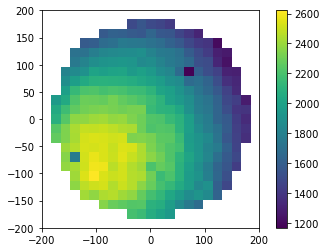

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 6.8
200000 / 584720
Est remaining = 5.4
300000 / 584720
Est remaining = 3.8
400000 / 584720
Est remaining = 2.5
500000 / 584720
Est remaining = 1.1


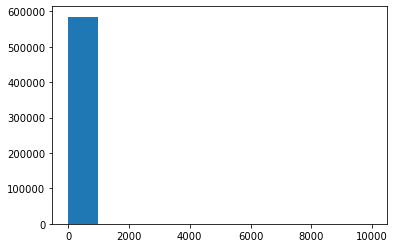

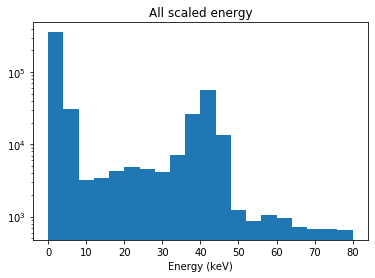

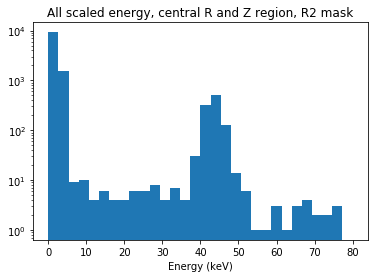

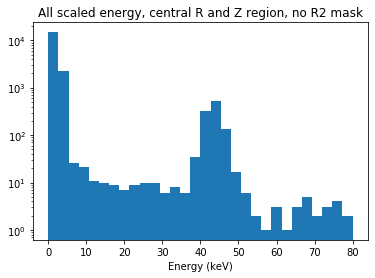

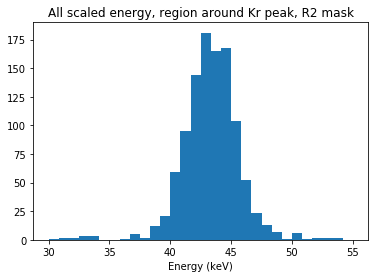

Correcting energies...
0 / 77066


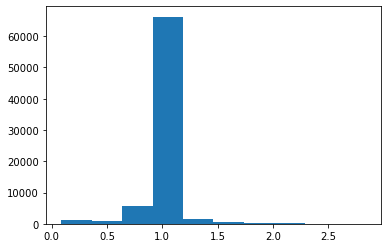

Fit a Gaussian with guess (A0, m0, s0) = (96.0, 1, 0.14105792637504702)


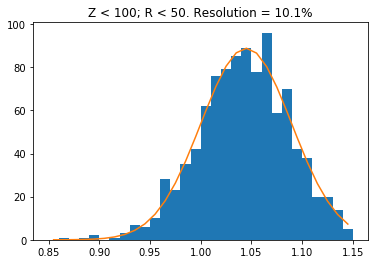

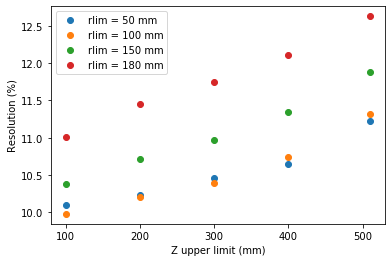

Innermost resolution =  10.09 %
Outermost resolution =  12.63 %
All resolutions: {100050: 10.094644129484015, 100100: 9.978083995861278, 100150: 10.37265572580588, 100180: 11.013362466991108, 200050: 10.233355631381816, 200100: 10.205895699917416, 200150: 10.71663527765529, 200180: 11.4506399896036, 300050: 10.456585851027352, 300100: 10.386429016664557, 300150: 10.962537494026387, 300180: 11.748357435006653, 400050: 10.65326268088652, 400100: 10.745684326473196, 400150: 11.341954078456736, 400180: 12.10508096036922, 510050: 11.21781498469502, 510100: 11.317737471275294, 510150: 11.874660759924776, 510180: 12.628371664165009}

================ CHECKING R2 CUT = 0.6 ================
Peak range = 282.4 , 3397.9
Selected percentage = 11.1 \%


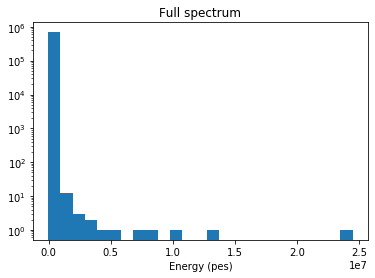

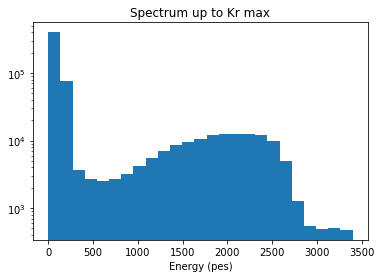

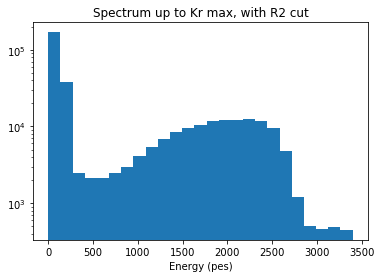

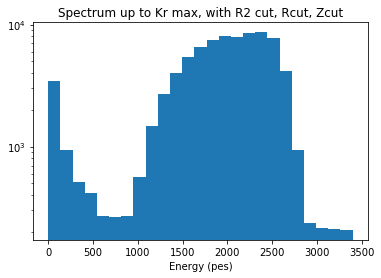

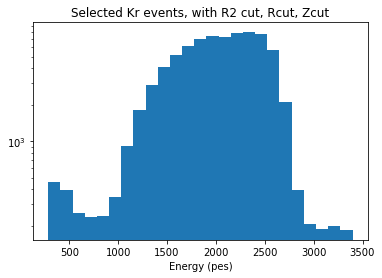

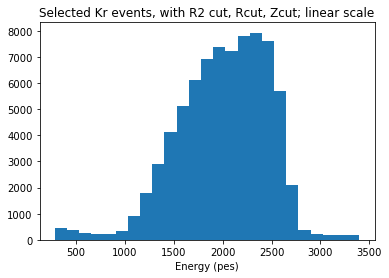

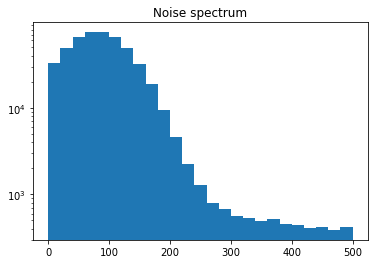

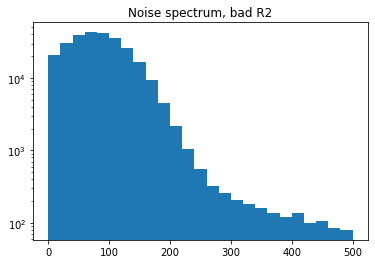

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


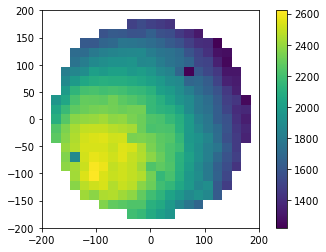

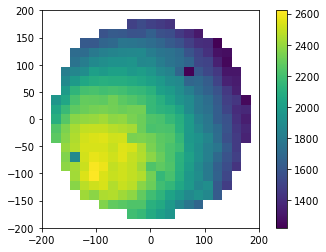

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 19.8
200000 / 584720
Est remaining = 11.9
300000 / 584720
Est remaining = 7.5
400000 / 584720
Est remaining = 4.2
500000 / 584720
Est remaining = 1.8


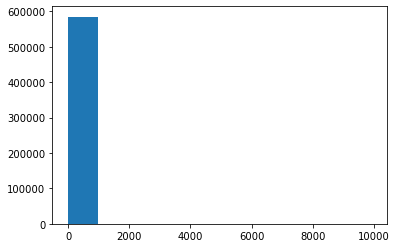

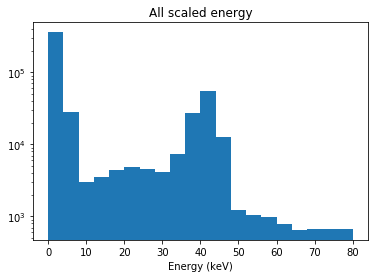

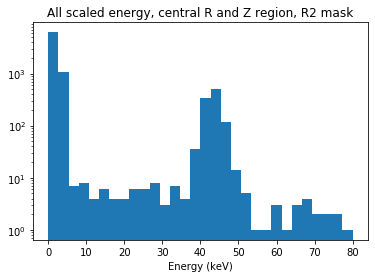

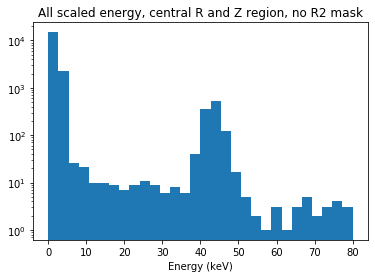

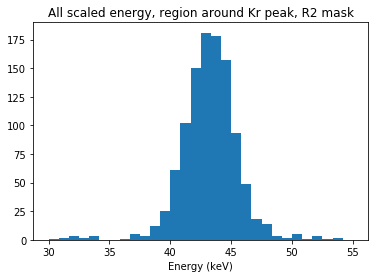

Correcting energies...
0 / 76748


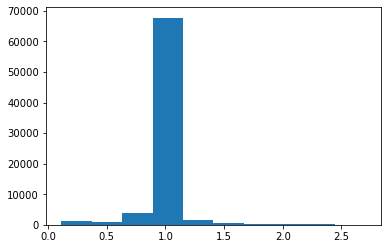

Fit a Gaussian with guess (A0, m0, s0) = (96.0, 1, 0.13784084216360404)


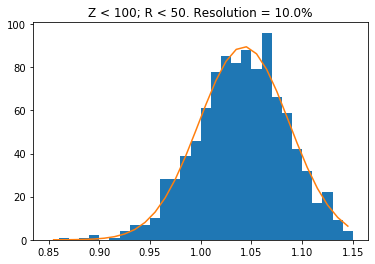

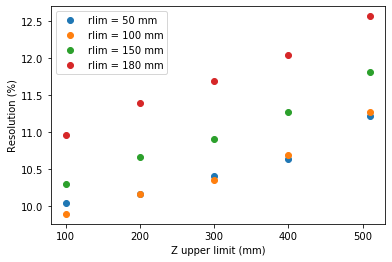

Innermost resolution =  10.04 %
Outermost resolution =  12.56 %
All resolutions: {100050: 10.042385098101978, 100100: 9.897422689876224, 100150: 10.303946734487297, 100180: 10.962134564712965, 200050: 10.161276395319309, 200100: 10.16497985313587, 200150: 10.662100420269551, 200180: 11.385920030707883, 300050: 10.407580610639688, 300100: 10.34821256352501, 300150: 10.910250872543864, 300180: 11.687673333545858, 400050: 10.633099638617166, 400100: 10.690780776584155, 400150: 11.274892760945068, 400180: 12.035379151243085, 510050: 11.210324267688371, 510100: 11.269869231714198, 510150: 11.809741217386405, 510180: 12.561248051280343}

================ CHECKING R2 CUT = 0.7 ================
Peak range = 357.2 , 3387.3
Selected percentage = 11.0 \%


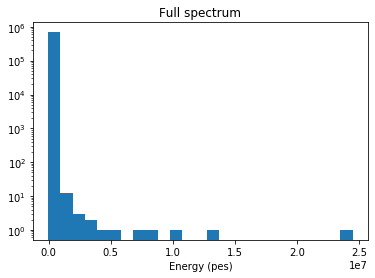

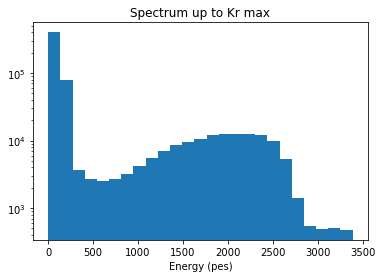

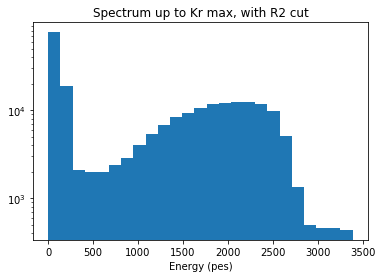

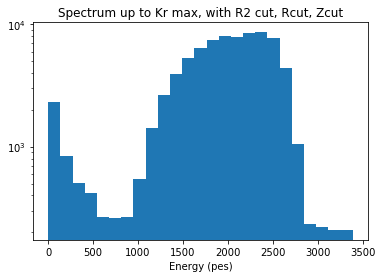

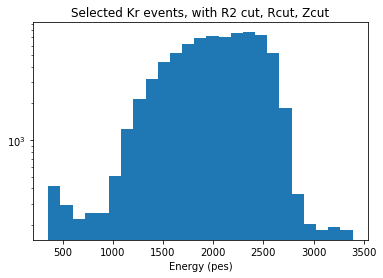

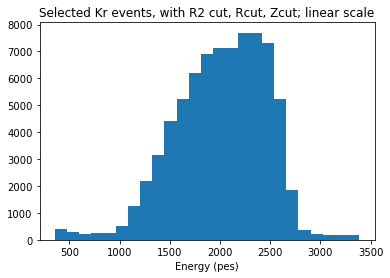

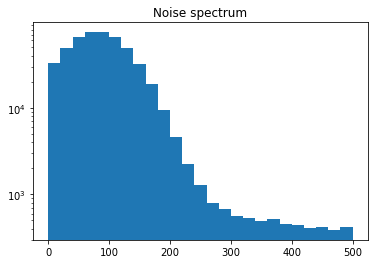

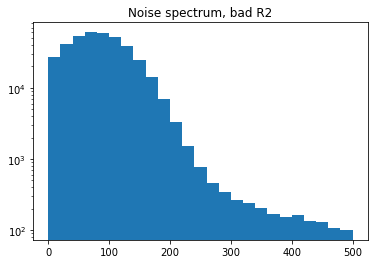

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


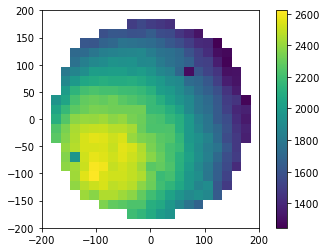

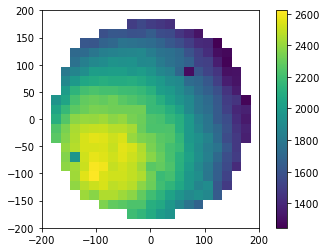

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 6.8
200000 / 584720
Est remaining = 5.4
300000 / 584720
Est remaining = 4.2
400000 / 584720
Est remaining = 3.0
500000 / 584720
Est remaining = 1.4


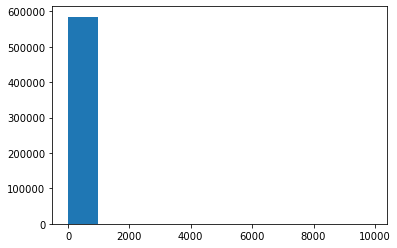

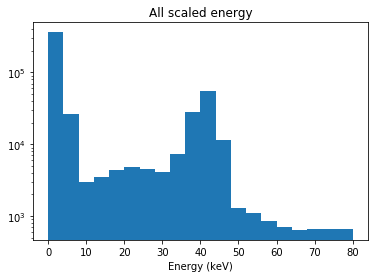

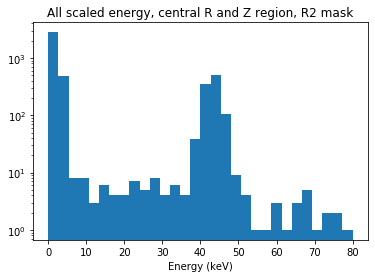

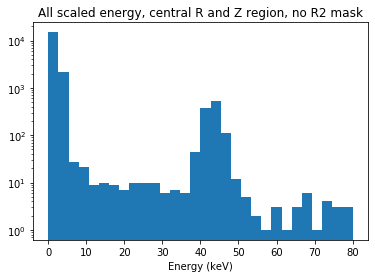

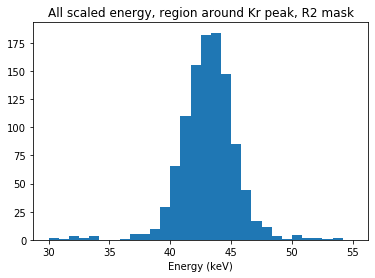

Correcting energies...
0 / 76410


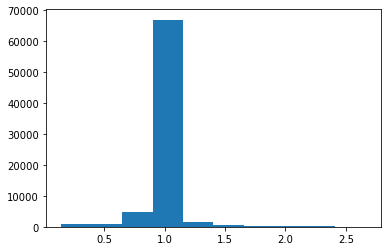

Fit a Gaussian with guess (A0, m0, s0) = (94.0, 1, 0.12959199635945498)


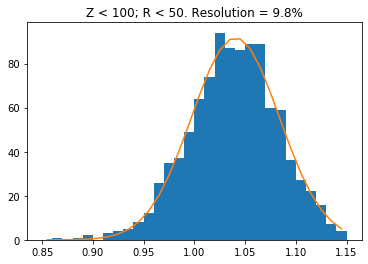

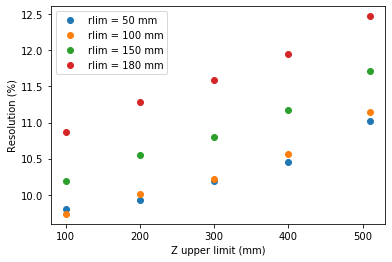

Innermost resolution =  9.81 %
Outermost resolution =  12.47 %
All resolutions: {100050: 9.809873332787676, 100100: 9.735111327102599, 100150: 10.191122812432805, 100180: 10.862356564202631, 200050: 9.931712466788179, 200100: 10.014690416779981, 200150: 10.552844910028572, 200180: 11.290165167360714, 300050: 10.196971085519504, 300100: 10.2250785617041, 300150: 10.799352872378966, 300180: 11.583194213244786, 400050: 10.449955293649037, 400100: 10.559901432911747, 400150: 11.172100170349344, 400180: 11.94195750534619, 510050: 11.02289802453029, 510100: 11.14873992253312, 510150: 11.715706846537646, 510180: 12.471381902334425}

================ CHECKING R2 CUT = 0.8 ================
Peak range = 436.0 , 3373.6
Selected percentage = 11.0 \%


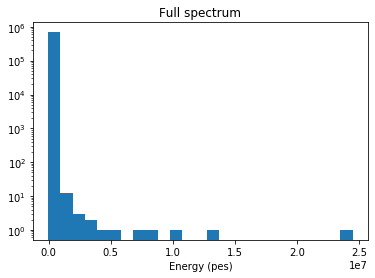

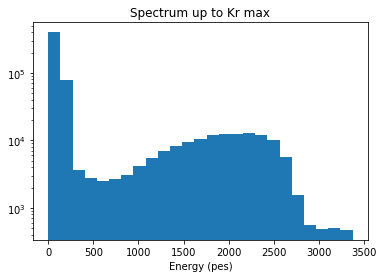

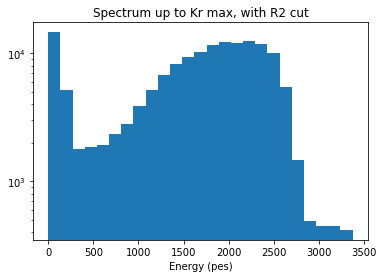

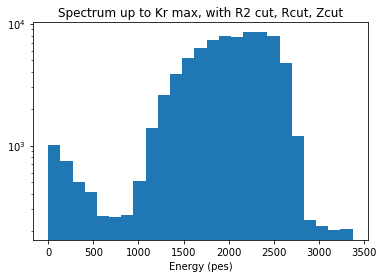

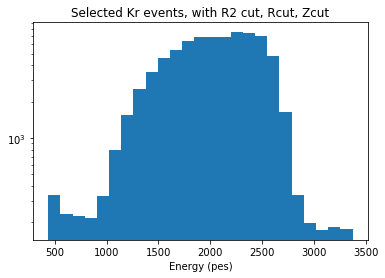

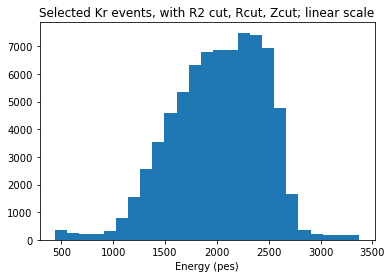

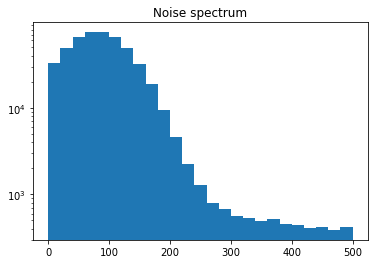

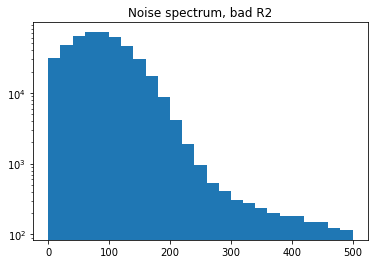

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


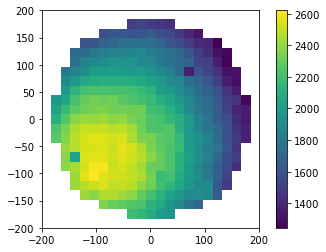

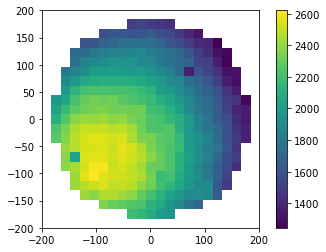

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 9.7
200000 / 584720
Est remaining = 6.6
300000 / 584720
Est remaining = 4.8
400000 / 584720
Est remaining = 3.0
500000 / 584720
Est remaining = 1.4


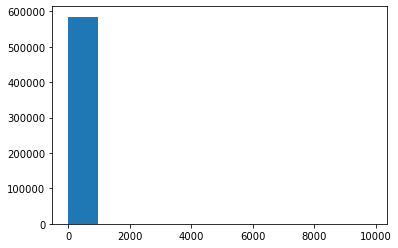

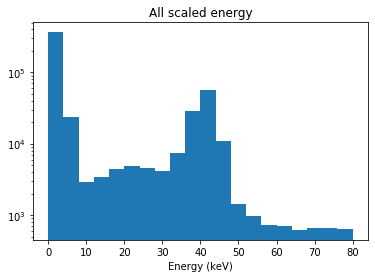

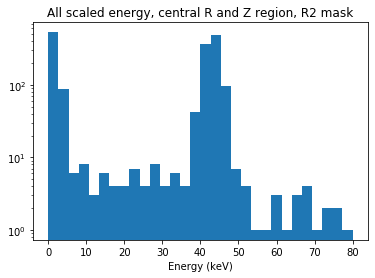

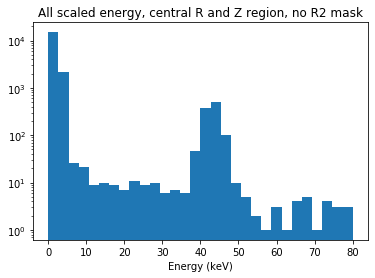

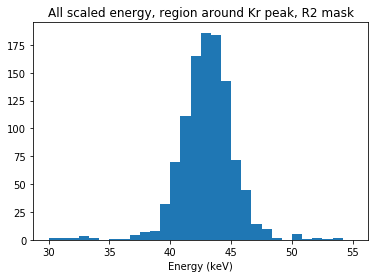

Correcting energies...
0 / 75902


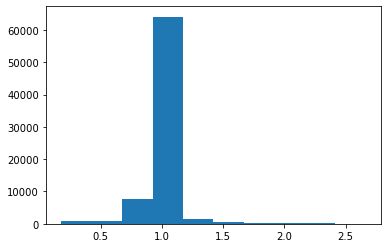

Fit a Gaussian with guess (A0, m0, s0) = (96.0, 1, 0.12445199953716433)


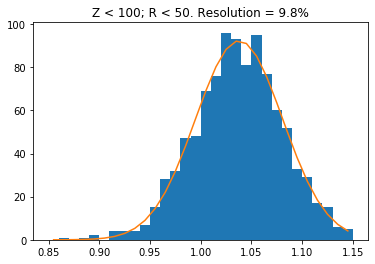

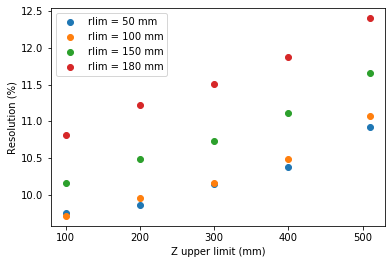

Innermost resolution =  9.76 %
Outermost resolution =  12.4 %
All resolutions: {100050: 9.757250226919815, 100100: 9.710753480323953, 100150: 10.157029972551323, 100180: 10.808770129406975, 200050: 9.861412310776318, 200100: 9.959774032857082, 200150: 10.486876833928106, 200180: 11.214658051936684, 300050: 10.151455228292471, 300100: 10.153330819256865, 300150: 10.733891995563452, 300180: 11.50830151724833, 400050: 10.371671744864825, 400100: 10.488717876335645, 400150: 11.112476931319119, 400180: 11.878177294134252, 510050: 10.921389793555644, 510100: 11.065167639229307, 510150: 11.653658591478177, 510180: 12.402379180434169}

================ CHECKING R2 CUT = 0.9 ================
Peak range = 472.1 , 3364.4
Selected percentage = 10.9 \%


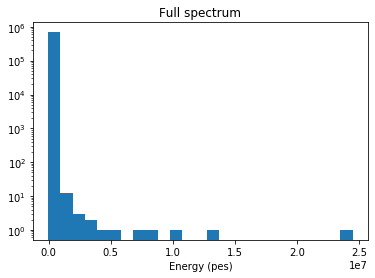

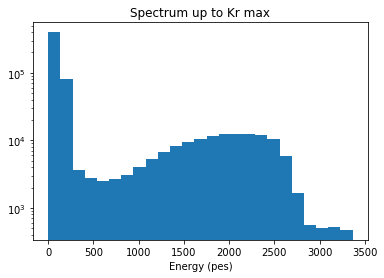

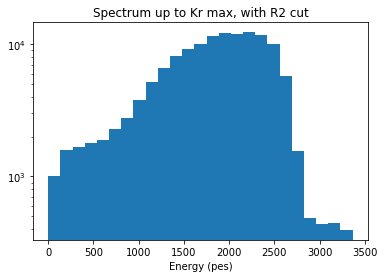

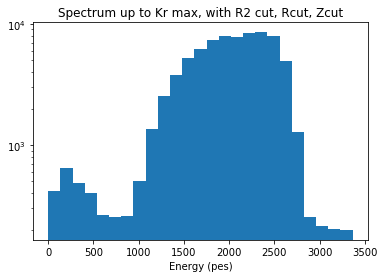

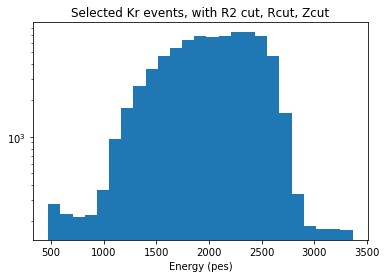

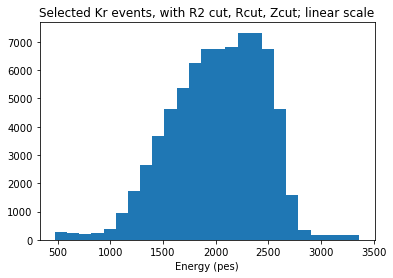

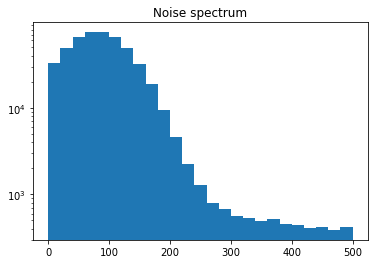

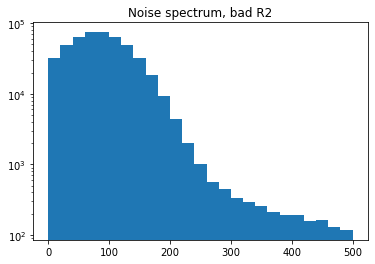

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


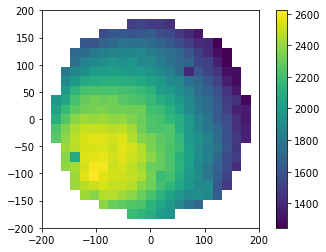

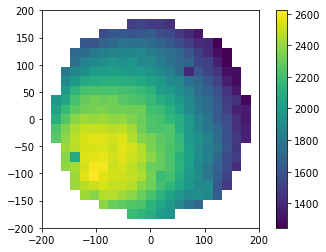

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 11.4
200000 / 584720
Est remaining = 9.2
300000 / 584720
Est remaining = 6.7
400000 / 584720
Est remaining = 4.3
500000 / 584720
Est remaining = 1.9


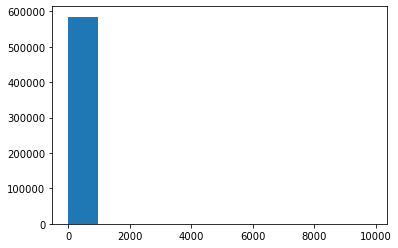

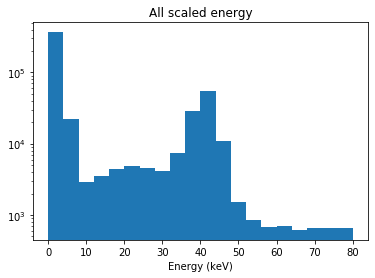

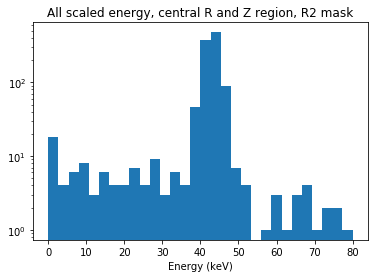

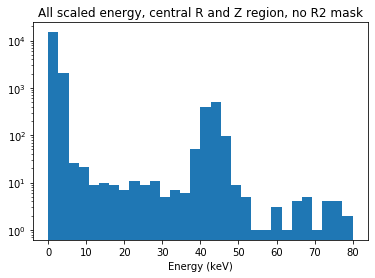

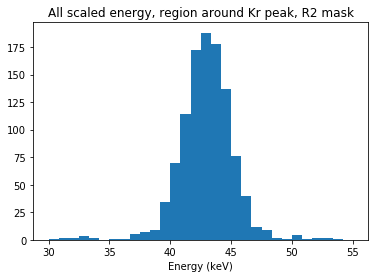

Correcting energies...
0 / 75540


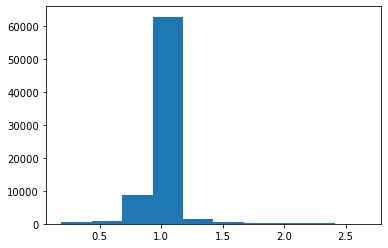

Fit a Gaussian with guess (A0, m0, s0) = (103.0, 1, 0.12201722015875498)


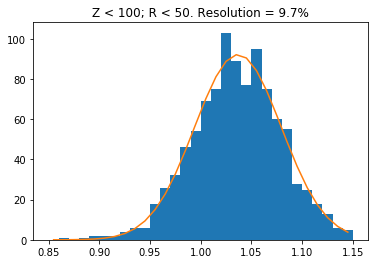

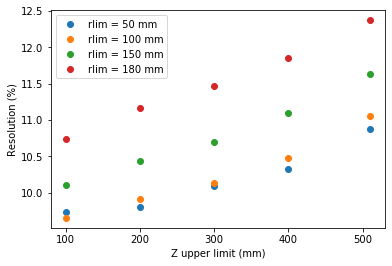

Innermost resolution =  9.74 %
Outermost resolution =  12.37 %
All resolutions: {100050: 9.740898618226472, 100100: 9.654801707998926, 100150: 10.105845264785284, 100180: 10.741375315865865, 200050: 9.810574790788237, 200100: 9.913067487163703, 200150: 10.436590941348715, 200180: 11.167196761827444, 300050: 10.098113537373033, 300100: 10.129592211797515, 300150: 10.701806571688454, 300180: 11.469288927422351, 400050: 10.332226463969462, 400100: 10.474295939669199, 400150: 11.090067259164478, 400180: 11.849958054100536, 510050: 10.878650727735382, 510100: 11.056324161082184, 510150: 11.630566071394824, 510180: 12.37079609643642}

================ CHECKING R2 CUT = 0.92 ================
Peak range = 479.4 , 3362.2
Selected percentage = 10.9 \%


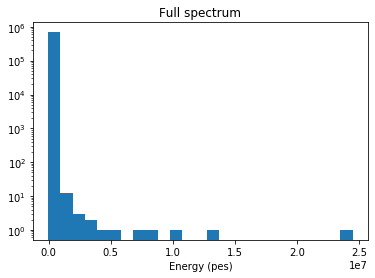

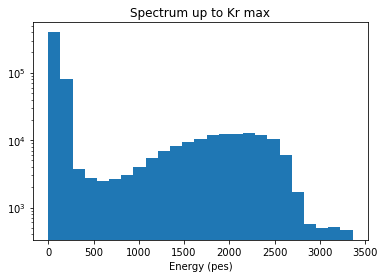

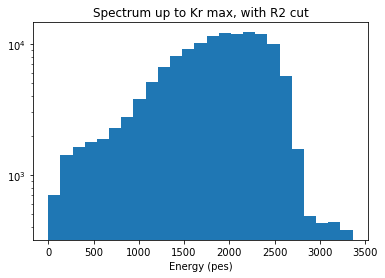

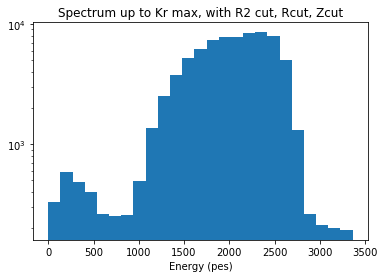

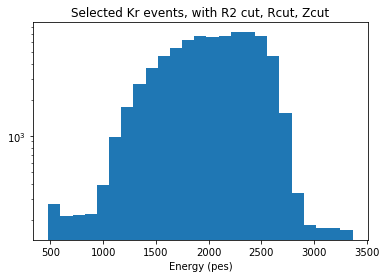

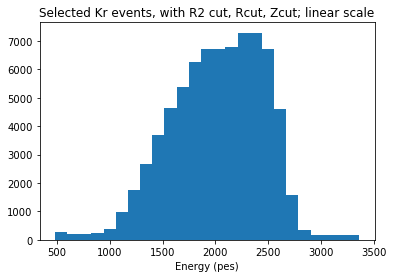

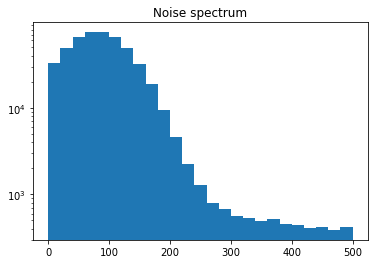

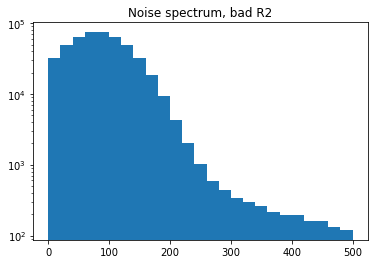

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


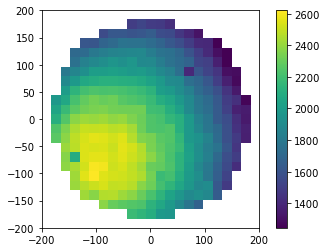

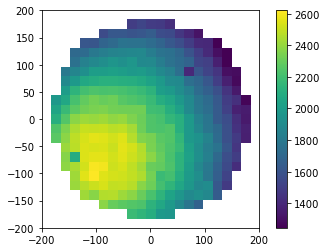

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 11.5
200000 / 584720
Est remaining = 9.6
300000 / 584720
Est remaining = 7.0
400000 / 584720
Est remaining = 4.5
500000 / 584720
Est remaining = 2.0


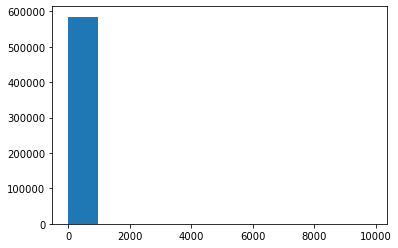

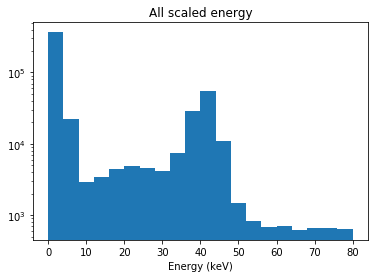

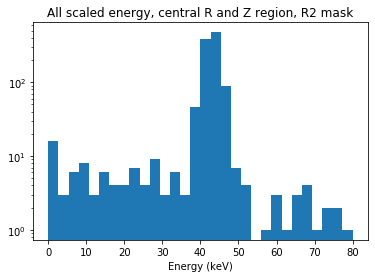

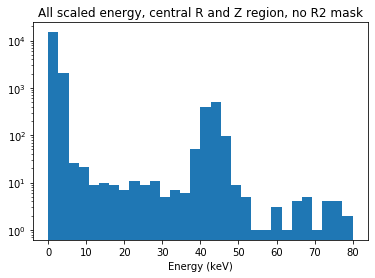

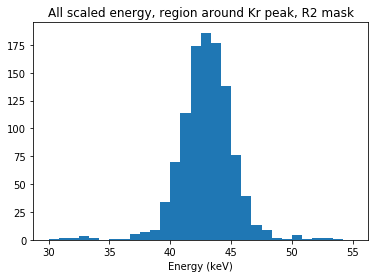

Correcting energies...
0 / 75444


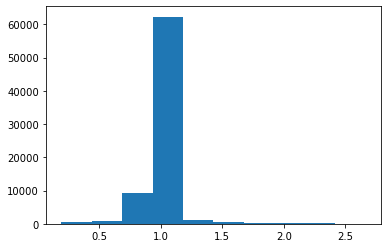

Fit a Gaussian with guess (A0, m0, s0) = (101.0, 1, 0.12203212177667293)


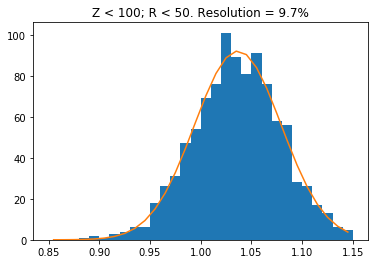

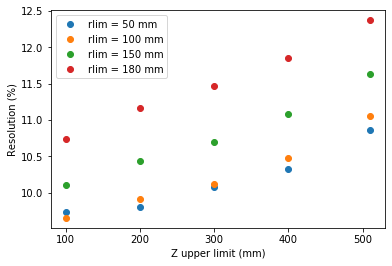

Innermost resolution =  9.74 %
Outermost resolution =  12.37 %
All resolutions: {100050: 9.738995225818558, 100100: 9.652134946570774, 100150: 10.101094252528839, 100180: 10.731530780575135, 200050: 9.804775645717758, 200100: 9.913771449749925, 200150: 10.435338042455319, 200180: 11.158955396018564, 300050: 10.082368628178735, 300100: 10.12461491202693, 300150: 10.695882878263305, 300180: 11.461533359871032, 400050: 10.323774300398883, 400100: 10.470798913029649, 400150: 11.08638092668621, 400180: 11.845622096739396, 510050: 10.867601288176022, 510100: 11.054007725486851, 510150: 11.630914157776438, 510180: 12.370890659513739}

================ CHECKING R2 CUT = 0.94 ================
Peak range = 488.5 , 3359.3
Selected percentage = 10.9 \%


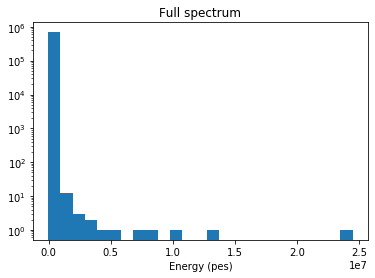

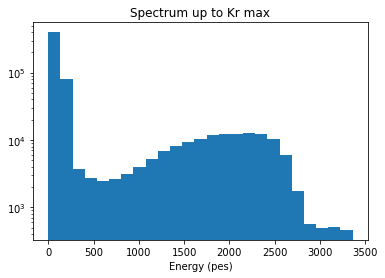

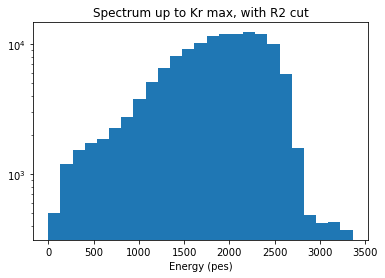

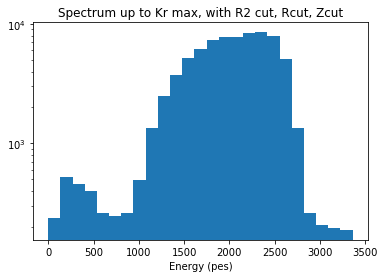

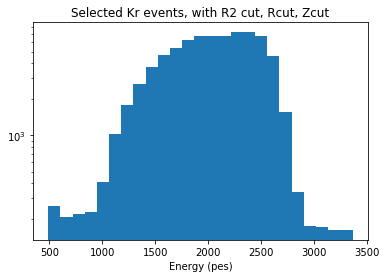

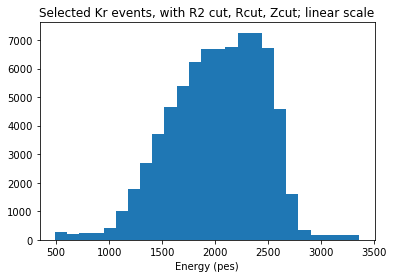

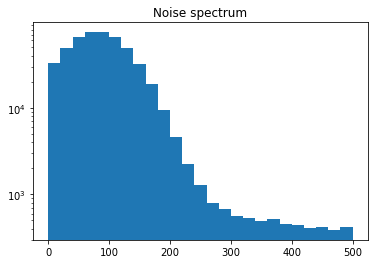

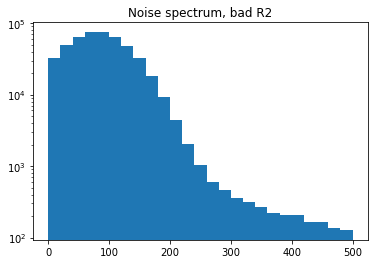

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


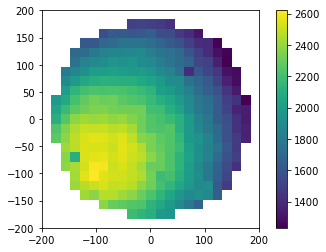

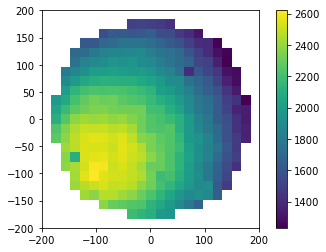

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 12.0
200000 / 584720
Est remaining = 9.0
300000 / 584720
Est remaining = 6.6
400000 / 584720
Est remaining = 4.2
500000 / 584720
Est remaining = 2.0


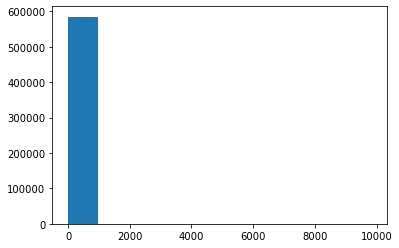

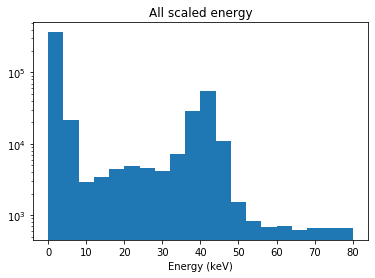

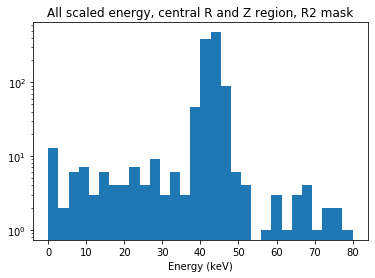

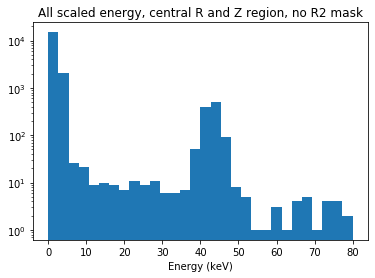

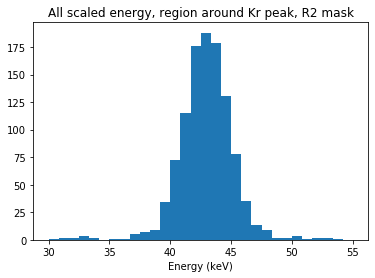

Correcting energies...
0 / 75345


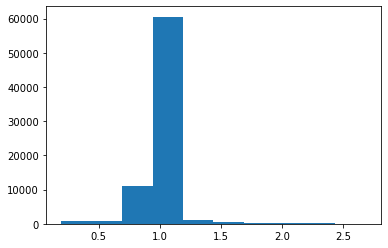

Fit a Gaussian with guess (A0, m0, s0) = (100.0, 1, 0.11450408839559216)


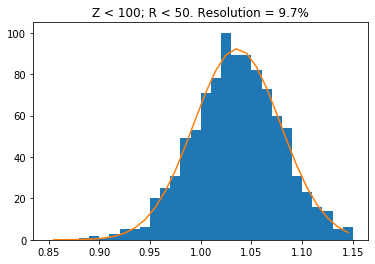

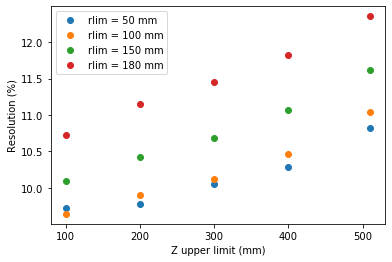

Innermost resolution =  9.73 %
Outermost resolution =  12.35 %
All resolutions: {100050: 9.728283911390822, 100100: 9.643790322995452, 100150: 10.098348585560545, 100180: 10.719277754330728, 200050: 9.783097851882177, 200100: 9.903158761928097, 200150: 10.424589925985279, 200180: 11.143925161671184, 300050: 10.052466482948896, 300100: 10.12148723753994, 300150: 10.685984786770854, 300180: 11.446586380565531, 400050: 10.285575501194616, 400100: 10.461833962293374, 400150: 11.070158737360714, 400180: 11.827386831696394, 510050: 10.82718373959507, 510100: 11.044776584076102, 510150: 11.615868032158556, 510180: 12.353696269760894}

================ CHECKING R2 CUT = 0.96 ================
Peak range = 505.8 , 3355.1
Selected percentage = 10.9 \%


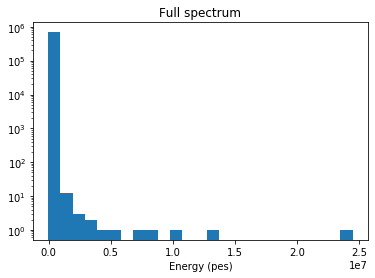

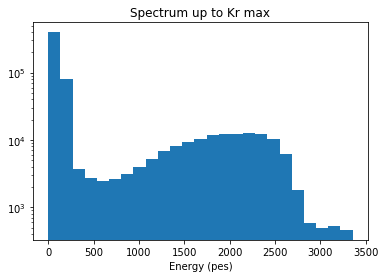

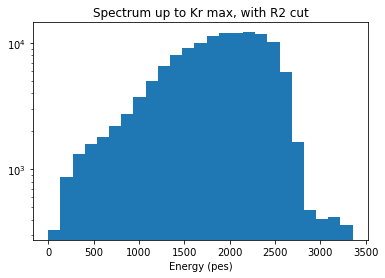

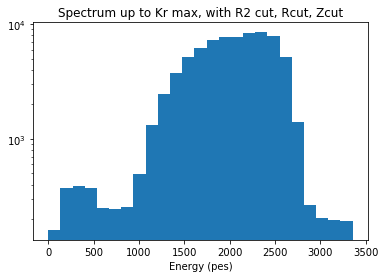

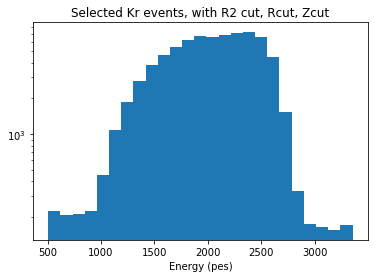

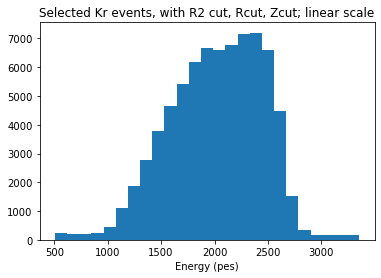

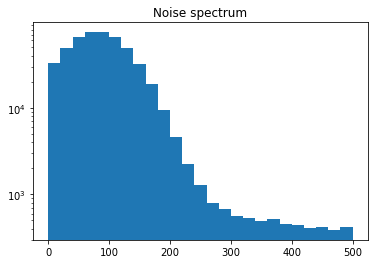

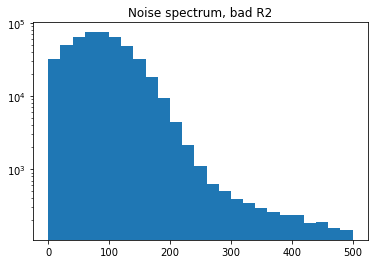

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


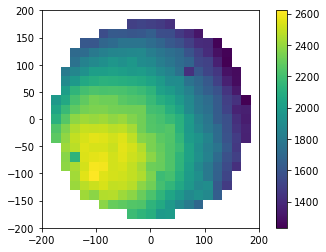

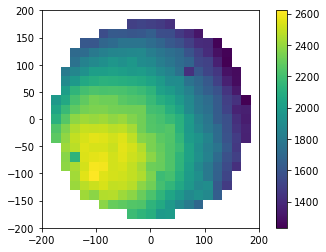

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 12.2
200000 / 584720
Est remaining = 10.6
300000 / 584720
Est remaining = 7.8
400000 / 584720
Est remaining = 4.9
500000 / 584720
Est remaining = 2.2


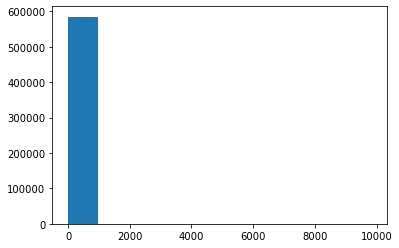

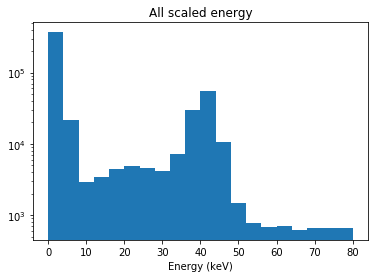

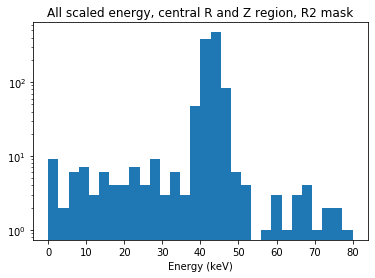

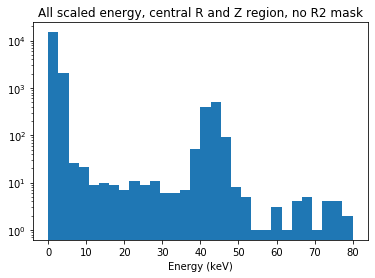

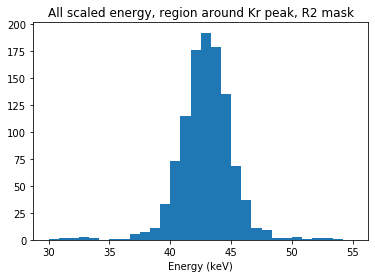

Correcting energies...
0 / 75147


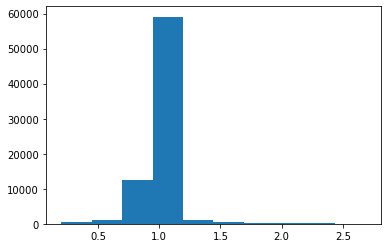

Fit a Gaussian with guess (A0, m0, s0) = (104.0, 1, 0.11171858790740428)


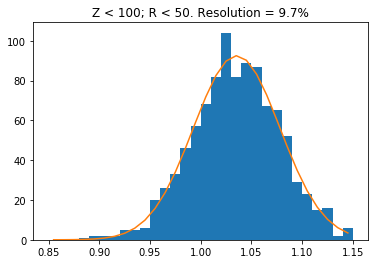

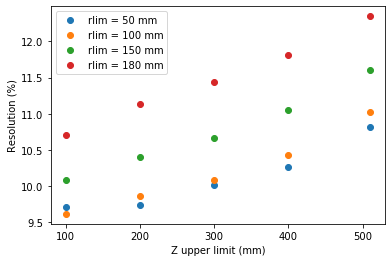

Innermost resolution =  9.72 %
Outermost resolution =  12.35 %
All resolutions: {100050: 9.717649555988134, 100100: 9.617856867093856, 100150: 10.082755863853206, 100180: 10.712908068128542, 200050: 9.747446469683847, 200100: 9.866391613955694, 200150: 10.409993533198396, 200180: 11.132883425080422, 300050: 10.018172790544996, 300100: 10.085104327443432, 300150: 10.666394418350539, 300180: 11.43173048287521, 400050: 10.267407840144555, 400100: 10.431774901002644, 400150: 11.054157800999318, 400180: 11.81454289536252, 510050: 10.821418896029826, 510100: 11.0188095204439, 510150: 11.603653791939974, 510180: 12.345495226508383}

================ CHECKING R2 CUT = 0.98 ================
Peak range = 536.6 , 3348.2
Selected percentage = 10.8 \%


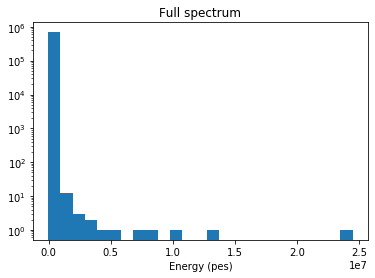

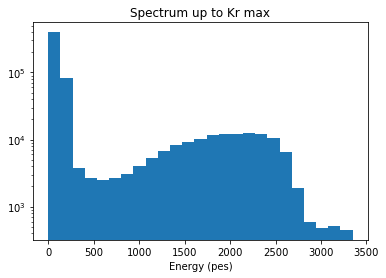

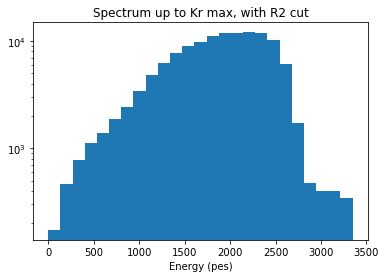

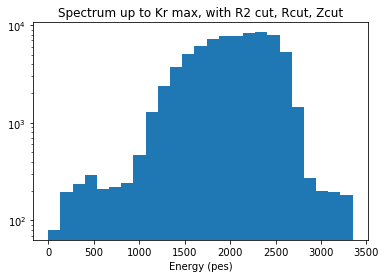

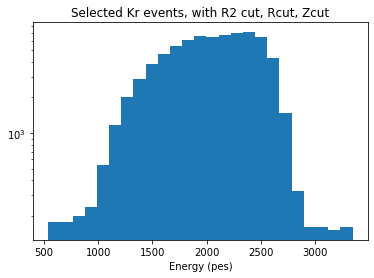

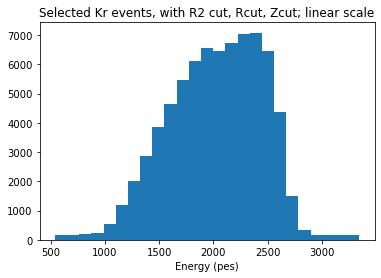

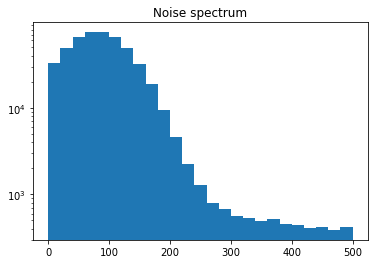

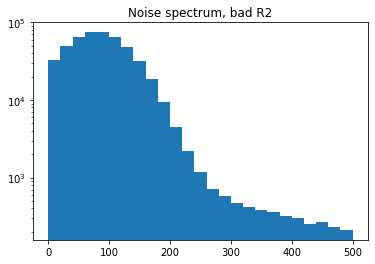

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


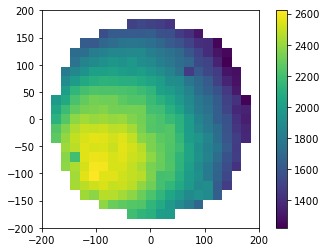

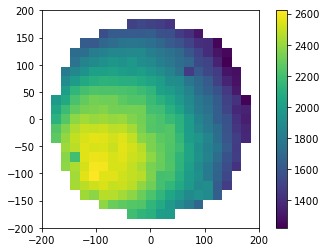

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 15.3
200000 / 584720
Est remaining = 12.1
300000 / 584720
Est remaining = 8.4
400000 / 584720
Est remaining = 5.3
500000 / 584720
Est remaining = 2.4


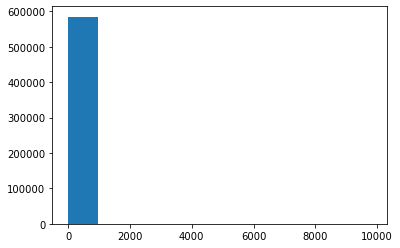

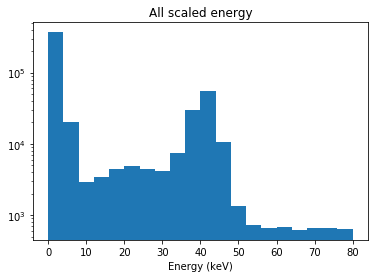

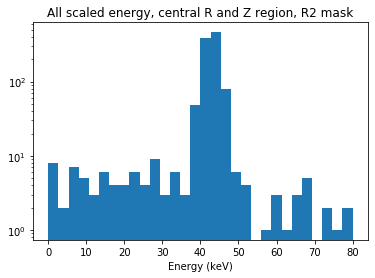

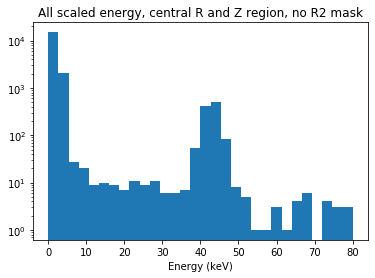

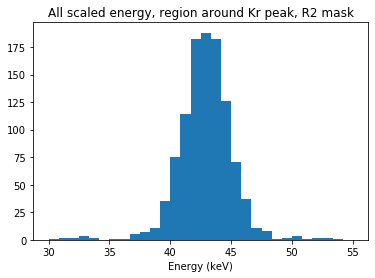

Correcting energies...
0 / 74602


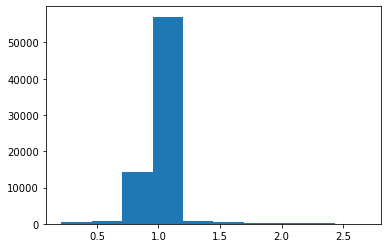

Fit a Gaussian with guess (A0, m0, s0) = (104.0, 1, 0.11082952677469782)


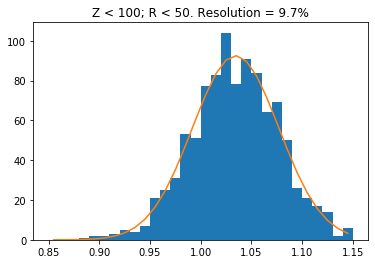

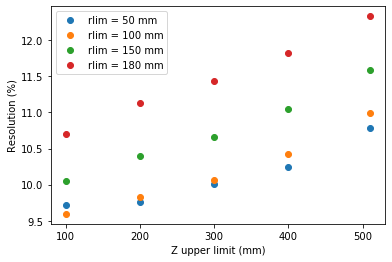

Innermost resolution =  9.72 %
Outermost resolution =  12.33 %
All resolutions: {100050: 9.720400666623323, 100100: 9.593903240950949, 100150: 10.056105035878957, 100180: 10.703691192100981, 200050: 9.759699117999421, 200100: 9.835105679950715, 200150: 10.393582265448408, 200180: 11.128151901734153, 300050: 10.008903693146582, 300100: 10.068650765018939, 300150: 10.660847760118157, 300180: 11.437247777055896, 400050: 10.238502774513293, 400100: 10.42001106222929, 400150: 11.047441572555867, 400180: 11.817964055722703, 510050: 10.786364210192493, 510100: 10.99676331330737, 510150: 11.58679537862818, 510180: 12.334194196373662}

================ CHECKING R2 CUT = 0.99 ================
Peak range = 591.5 , 3333.9
Selected percentage = 10.2 \%


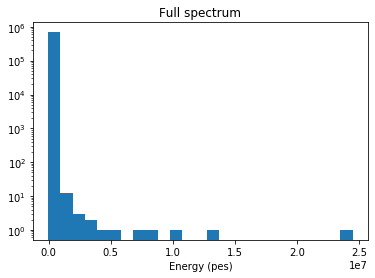

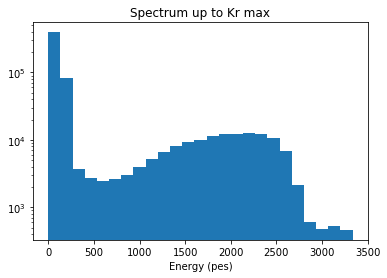

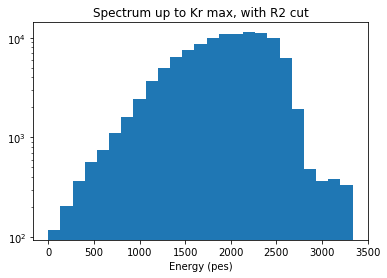

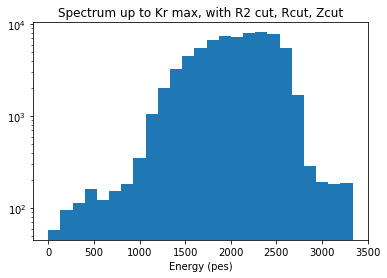

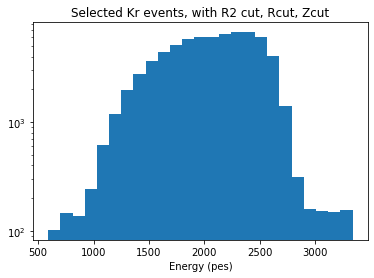

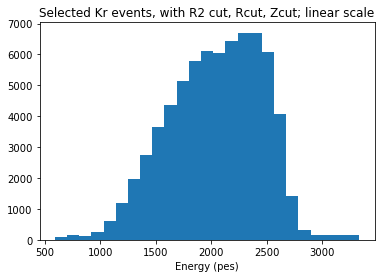

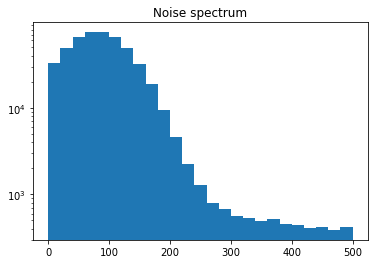

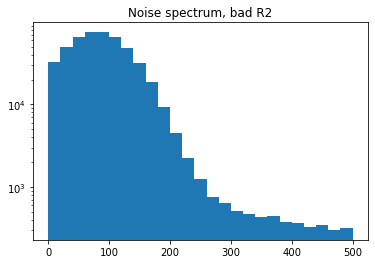

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


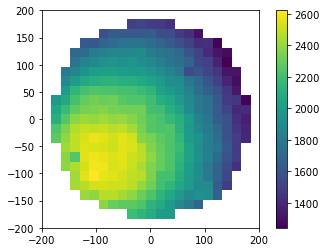

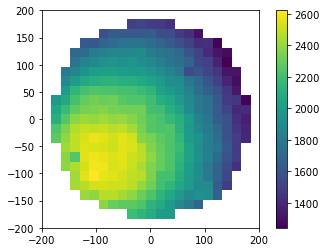

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 19.3
200000 / 584720
Est remaining = 14.4
300000 / 584720
Est remaining = 10.5
400000 / 584720
Est remaining = 6.9
500000 / 584720
Est remaining = 3.5


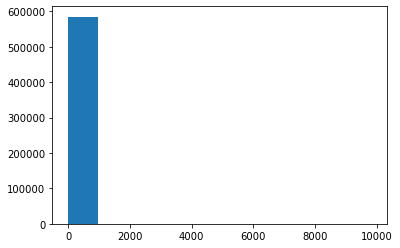

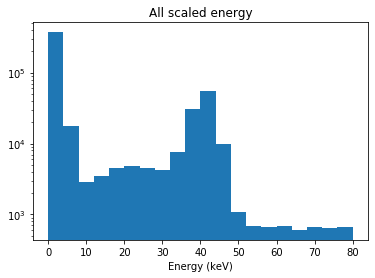

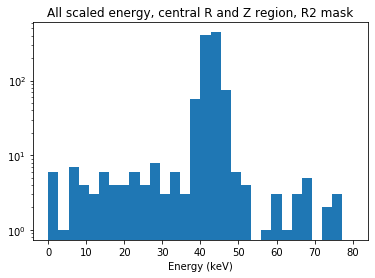

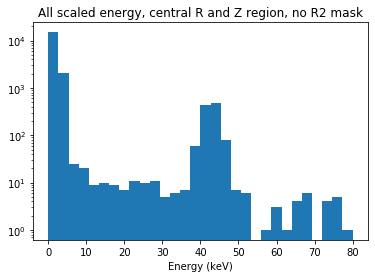

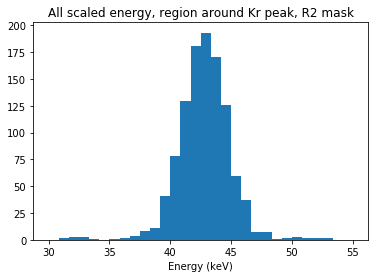

Correcting energies...
0 / 70579


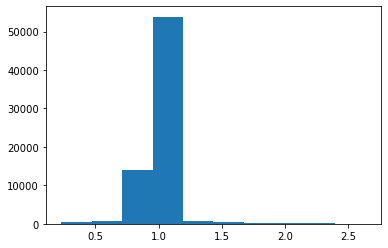

Fit a Gaussian with guess (A0, m0, s0) = (101.0, 1, 0.10748024065025688)


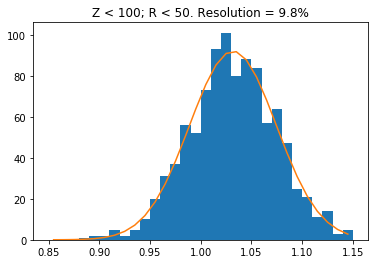

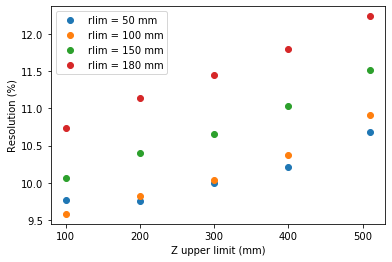

Innermost resolution =  9.77 %
Outermost resolution =  12.24 %
All resolutions: {100050: 9.771283743801636, 100100: 9.58363474755473, 100150: 10.06649648367237, 100180: 10.73223572214207, 200050: 9.761690831037685, 200100: 9.82837733531326, 200150: 10.397273571754383, 200180: 11.141476605899767, 300050: 9.99414865609145, 300100: 10.037710648692414, 300150: 10.655853263423372, 300180: 11.446666581375728, 400050: 10.216741564255663, 400100: 10.379629110085634, 400150: 11.028091139152322, 400180: 11.79439713594286, 510050: 10.677622160108543, 510100: 10.914064512506394, 510150: 11.509793648572554, 510180: 12.237402830314258}

================ CHECKING R2 CUT = 0.995 ================
Peak range = 653.8 , 3321.6
Selected percentage = 7.9 \%


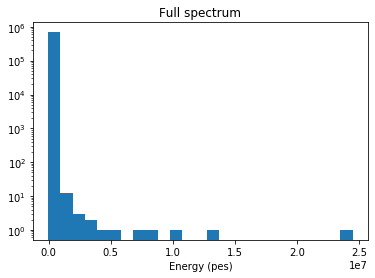

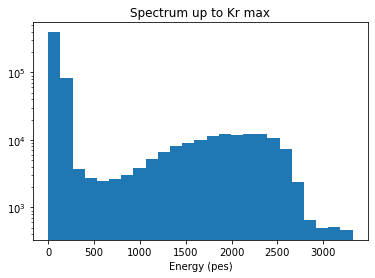

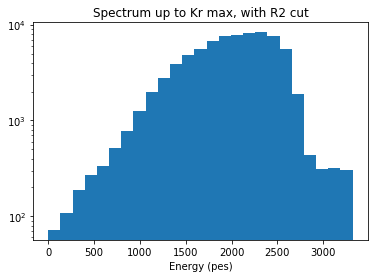

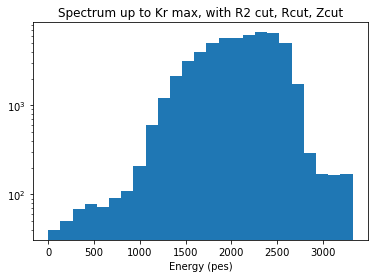

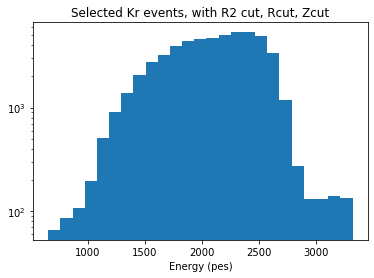

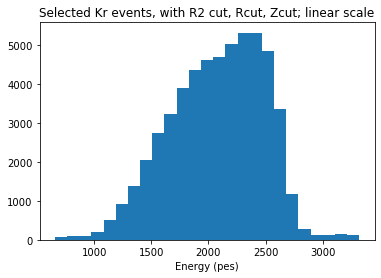

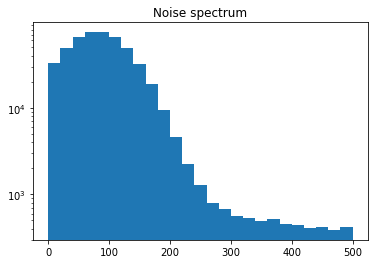

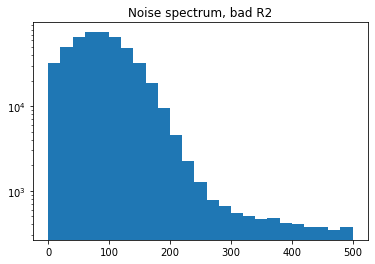

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


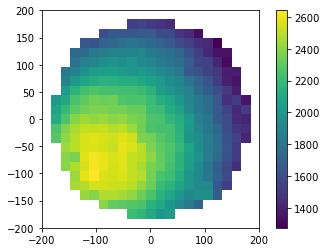

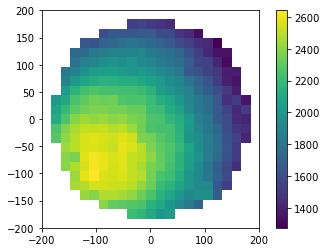

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 18.0
200000 / 584720
Est remaining = 13.9
300000 / 584720
Est remaining = 10.3
400000 / 584720
Est remaining = 6.7
500000 / 584720
Est remaining = 3.1


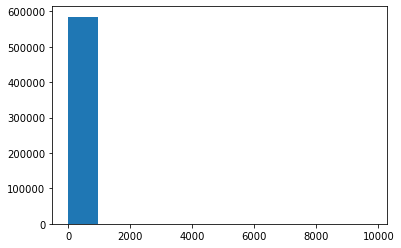

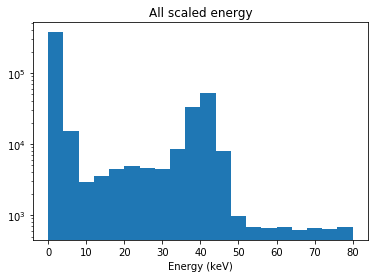

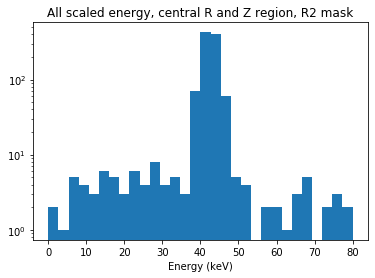

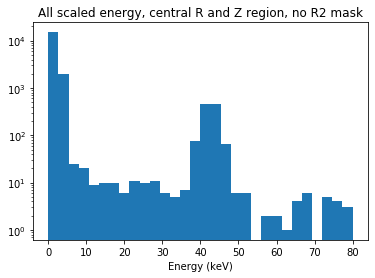

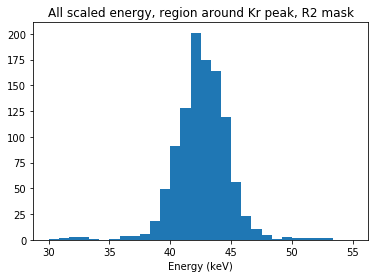

Correcting energies...
0 / 54736


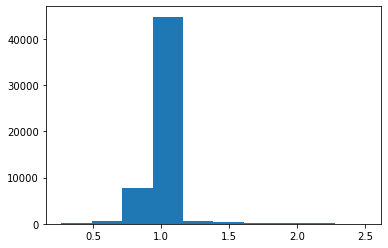

Fit a Gaussian with guess (A0, m0, s0) = (100.0, 1, 0.10788522562377632)


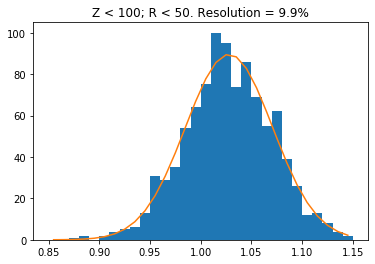

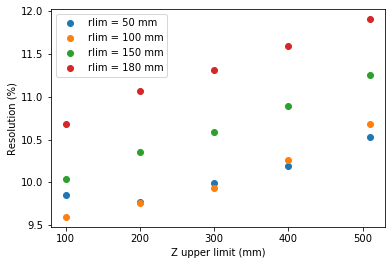

Innermost resolution =  9.85 %
Outermost resolution =  11.91 %
All resolutions: {100050: 9.851516915903556, 100100: 9.59630216999256, 100150: 10.044605421506338, 100180: 10.682226623917153, 200050: 9.77026790402233, 200100: 9.753599603179165, 200150: 10.359853114900003, 200180: 11.066248823175277, 300050: 9.991054626651431, 300100: 9.931142861145423, 300150: 10.585598917531449, 300180: 11.317972416735675, 400050: 10.18968259467874, 400100: 10.259170654819004, 400150: 10.893464661870757, 400180: 11.595896631767813, 510050: 10.52576265990866, 510100: 10.68457069783467, 510150: 11.25816076608035, 510180: 11.905817612950015}


In [19]:
# r2 scan
r2s = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.995])
res_vs_zr_vs_r2 = []
goodfit = []
for r2 in r2s:
    print('\n================ CHECKING R2 CUT =', r2, '================')
    try:
        self_res_vs_zr = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, r2)
        res_vs_zr_vs_r2.append(self_res_vs_zr)
        goodfit.append(True)
    except:
        goodfit.append(False)
goodfit = np.array(goodfit)

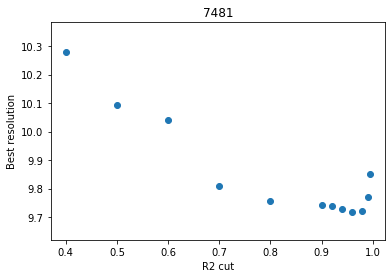

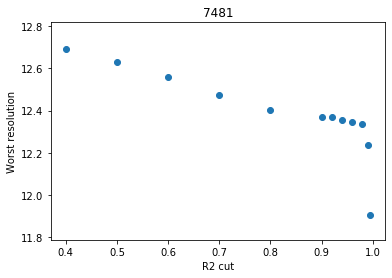

In [20]:
r2inner = [ list(x.values())[0] for x in res_vs_zr_vs_r2 ]
r2outer = [ list(x.values())[-1] for x in res_vs_zr_vs_r2 ]

plt.plot(r2s[goodfit], r2inner, 'o')
plt.ylim(min(r2inner)*0.99, max(r2inner)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Best resolution')
plt.show()

plt.plot(r2s[goodfit], r2outer, 'o')
plt.ylim(min(r2outer)*0.99, max(r2outer)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Worst resolution')
plt.show()

Peak range = 472.1 , 3364.4
Selected percentage = 10.9 \%


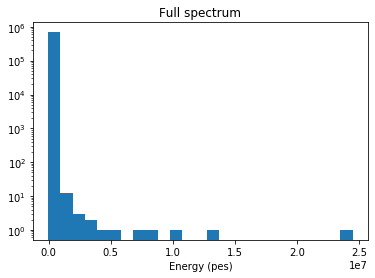

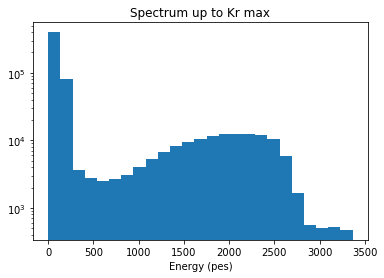

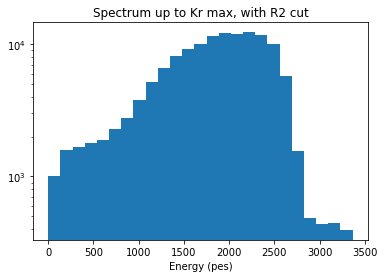

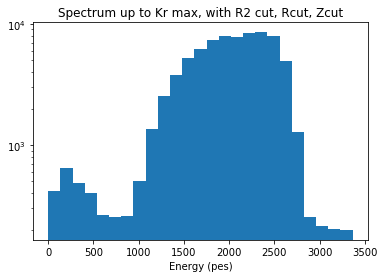

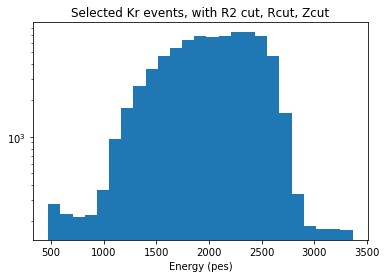

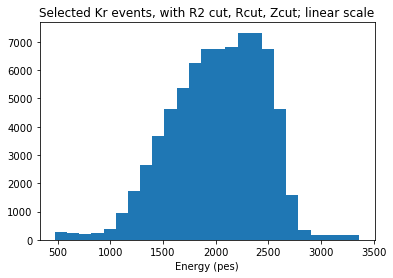

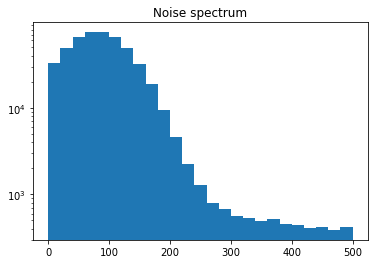

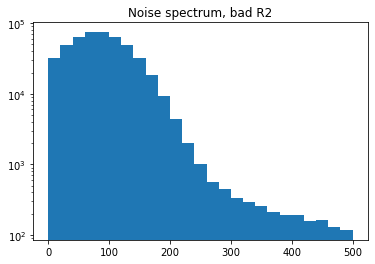

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


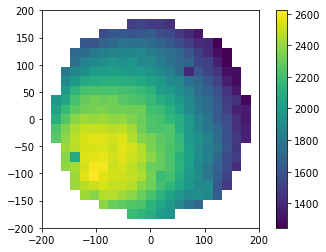

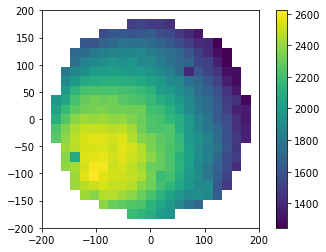

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 18.4
200000 / 584720
Est remaining = 14.6
300000 / 584720
Est remaining = 11.7
400000 / 584720
Est remaining = 7.7
500000 / 584720
Est remaining = 3.5


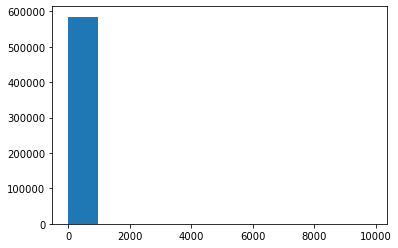

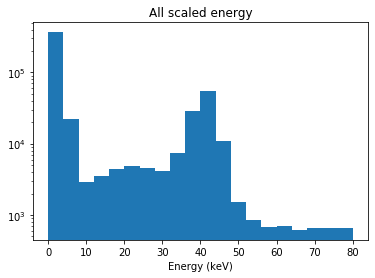

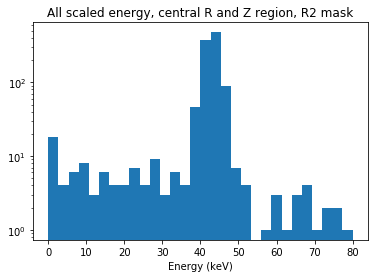

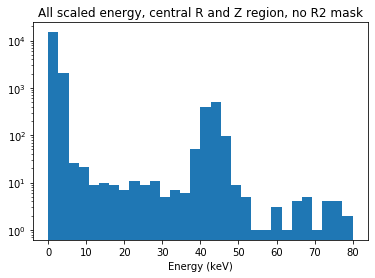

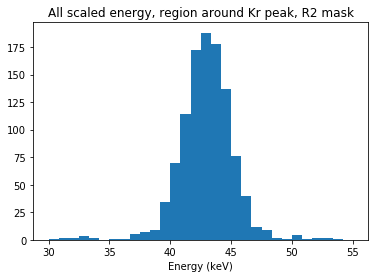

Correcting energies...
0 / 75540


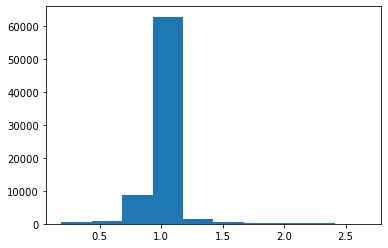

Fit a Gaussian with guess (A0, m0, s0) = (103.0, 1, 0.12201722015875498)


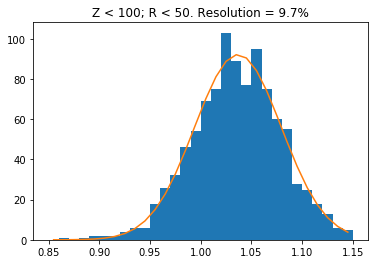

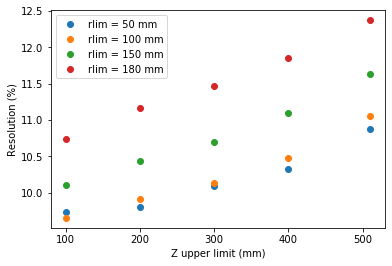

Innermost resolution =  9.74 %
Outermost resolution =  12.37 %
All resolutions: {100050: 9.740898618226472, 100100: 9.654801707998926, 100150: 10.105845264785284, 100180: 10.741375315865865, 200050: 9.810574790788237, 200100: 9.913067487163703, 200150: 10.436590941348715, 200180: 11.167196761827444, 300050: 10.098113537373033, 300100: 10.129592211797515, 300150: 10.701806571688454, 300180: 11.469288927422351, 400050: 10.332226463969462, 400100: 10.474295939669199, 400150: 11.090067259164478, 400180: 11.849958054100536, 510050: 10.878650727735382, 510100: 11.056324161082184, 510150: 11.630566071394824, 510180: 12.37079609643642}
Peak range = 492.1 , 3392.5
Selected percentage = 10.9 \%


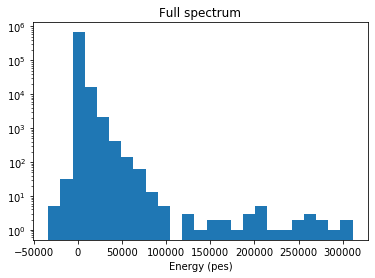

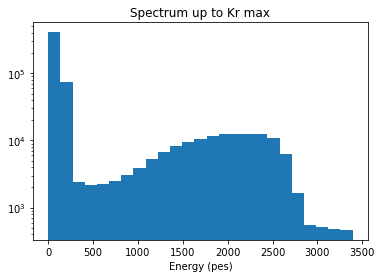

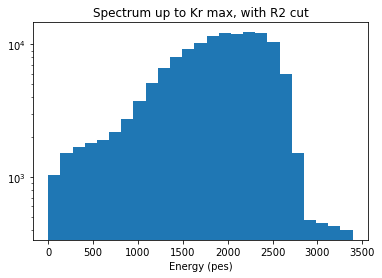

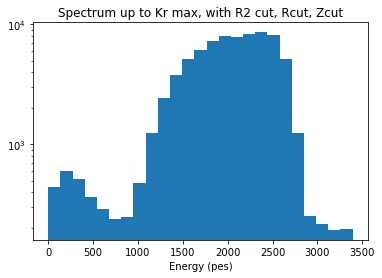

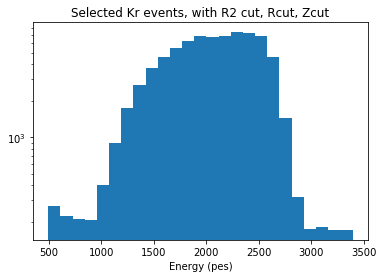

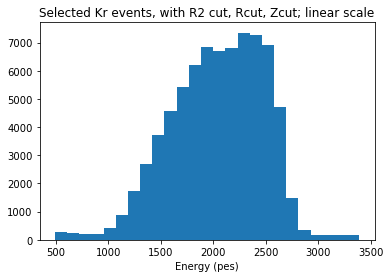

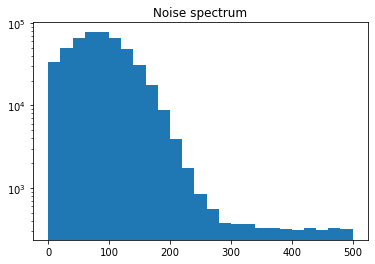

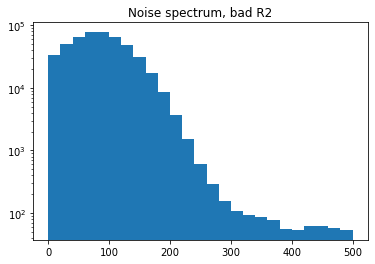

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


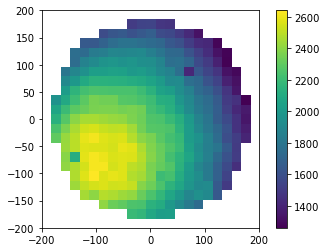

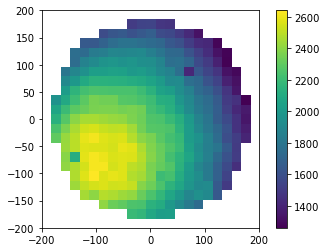

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 22.2
200000 / 584720
Est remaining = 22.7
300000 / 584720
Est remaining = 17.5
400000 / 584720
Est remaining = 10.8
500000 / 584720
Est remaining = 5.0


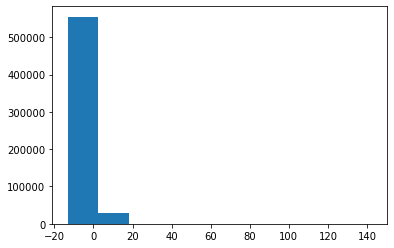

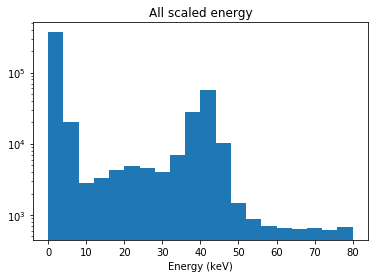

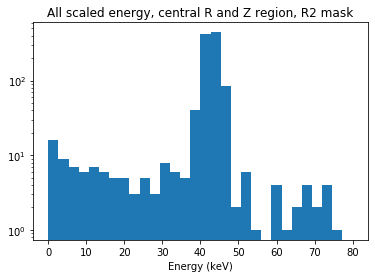

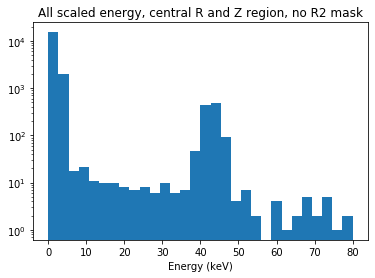

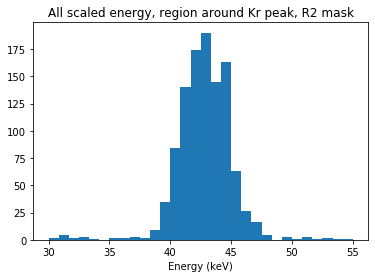

Correcting energies...
0 / 75590


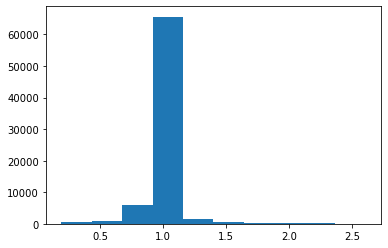

Fit a Gaussian with guess (A0, m0, s0) = (95.0, 1, 0.11796511844010671)


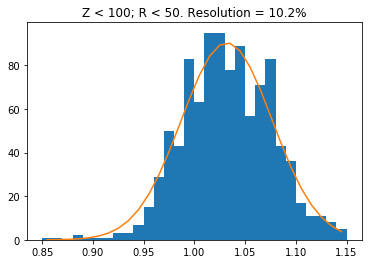

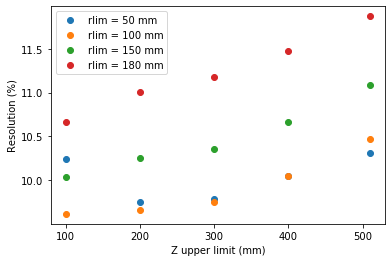

Innermost resolution =  10.24 %
Outermost resolution =  11.87 %
All resolutions: {100050: 10.237503372358875, 100100: 9.616420895233466, 100150: 10.033144335888787, 100180: 10.66314072827734, 200050: 9.747254376201695, 200100: 9.66275767379132, 200150: 10.250462802373368, 200180: 11.00532397283885, 300050: 9.780971393655056, 300100: 9.754439971603412, 300150: 10.361096240154797, 300180: 11.172656641165753, 400050: 10.046786365958505, 400100: 10.052607159953281, 400150: 10.667430447948393, 400180: 11.478240157044478, 510050: 10.312223864529303, 510100: 10.471613821324981, 510150: 11.084281471292229, 510180: 11.871296454965979}
Peak range = 492.1 , 3392.5
Selected percentage = 10.9 \%


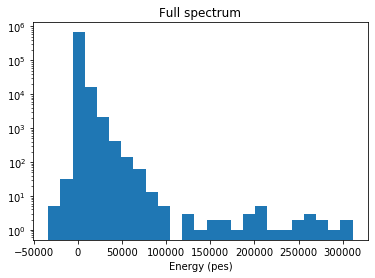

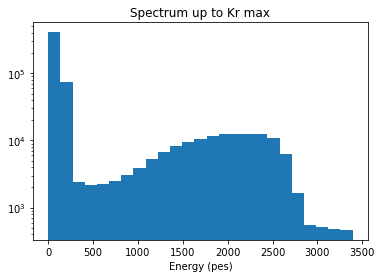

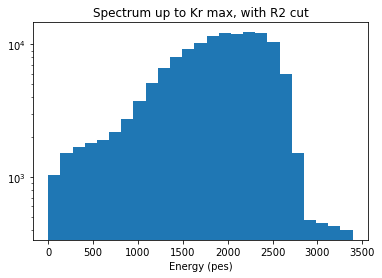

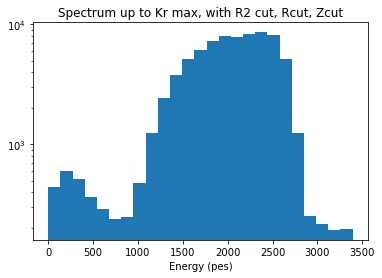

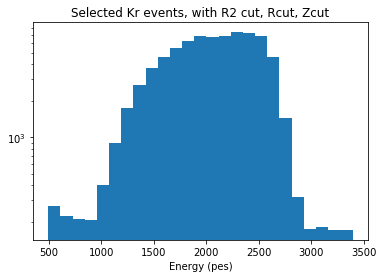

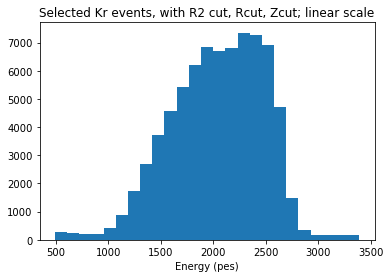

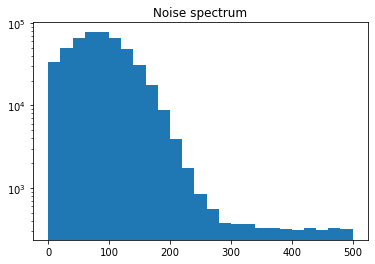

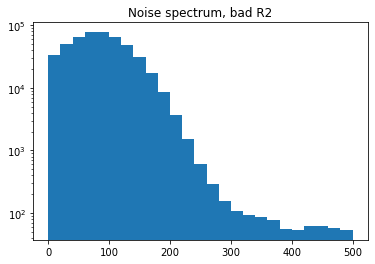

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


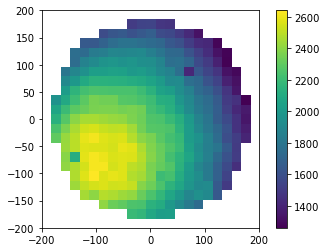

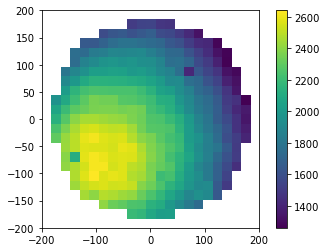

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 23.0
200000 / 584720
Est remaining = 18.7
300000 / 584720
Est remaining = 13.9
400000 / 584720
Est remaining = 9.2
500000 / 584720
Est remaining = 4.2


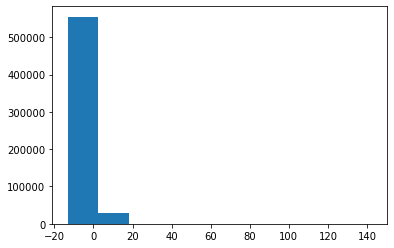

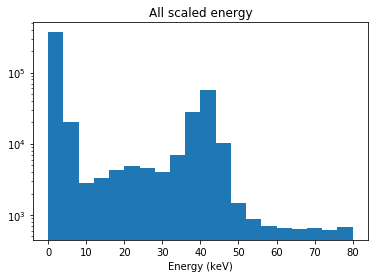

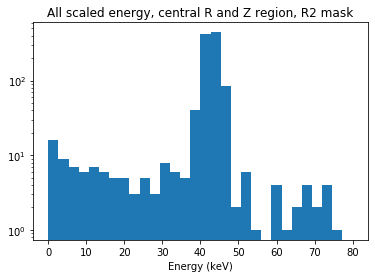

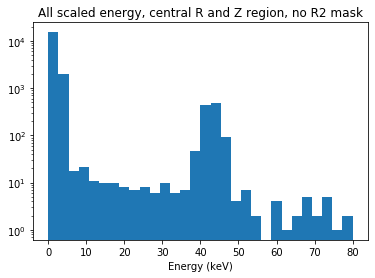

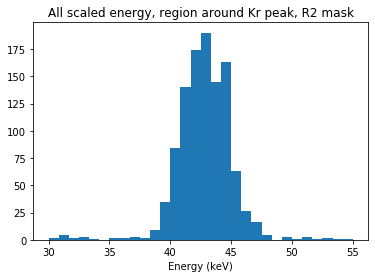

Correcting energies...
0 / 75590


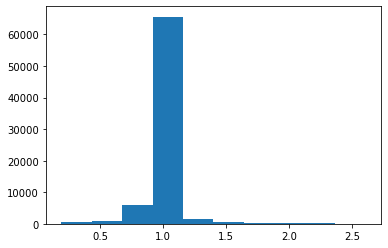

Fit a Gaussian with guess (A0, m0, s0) = (95.0, 1, 0.11796511844010671)


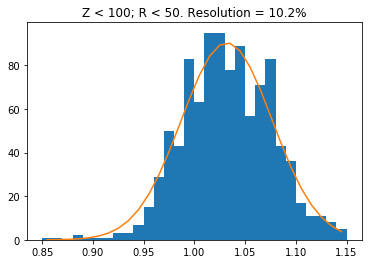

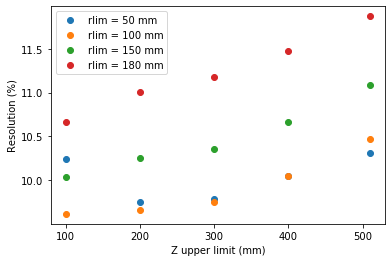

Innermost resolution =  10.24 %
Outermost resolution =  11.87 %
All resolutions: {100050: 10.237503372358875, 100100: 9.616420895233466, 100150: 10.033144335888787, 100180: 10.66314072827734, 200050: 9.747254376201695, 200100: 9.66275767379132, 200150: 10.250462802373368, 200180: 11.00532397283885, 300050: 9.780971393655056, 300100: 9.754439971603412, 300150: 10.361096240154797, 300180: 11.172656641165753, 400050: 10.046786365958505, 400100: 10.052607159953281, 400150: 10.667430447948393, 400180: 11.478240157044478, 510050: 10.312223864529303, 510100: 10.471613821324981, 510150: 11.084281471292229, 510180: 11.871296454965979}


In [21]:
try:
    pre_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    post_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_post, 0.9)
    avg_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_avg, 0.9)
except:
    pass

In [22]:
try:
    print('Inner res for pre, post, avg:')
    print(round(list(pre_res.values())[0], 2), ',', round(list(post_res.values())[0], 2), ',', round(list(avg_res.values())[0], 2))
    print('Outer res for pre, post, avg:')
    print(round(list(pre_res.values())[-1], 2), ',', round(list(post_res.values())[-1], 2), ',', round(list(avg_res.values())[-1], 2))
except:
    pass

Inner res for pre, post, avg:
9.74 , 10.24 , 10.24
Outer res for pre, post, avg:
12.37 , 11.87 , 11.87


Peak range = 472.1 , 3364.4
Selected percentage = 10.9 \%


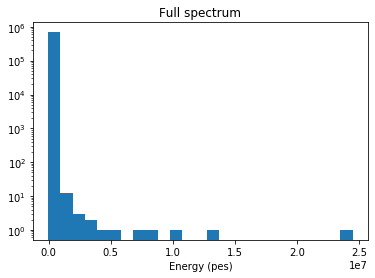

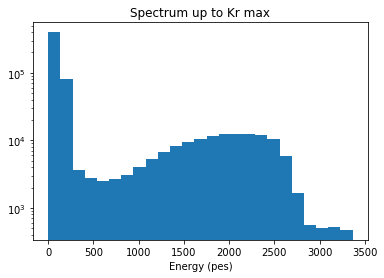

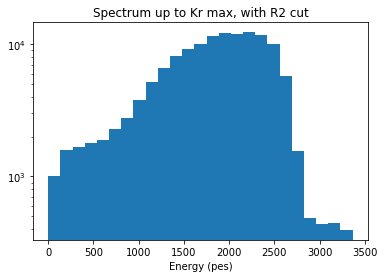

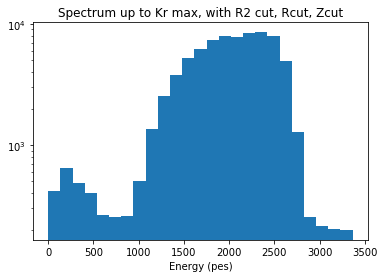

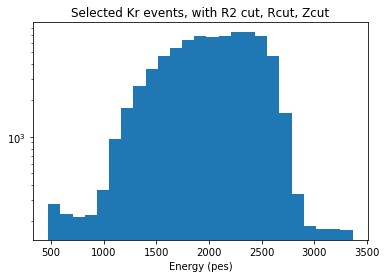

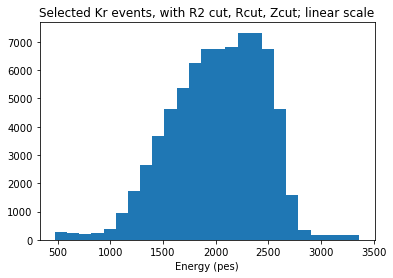

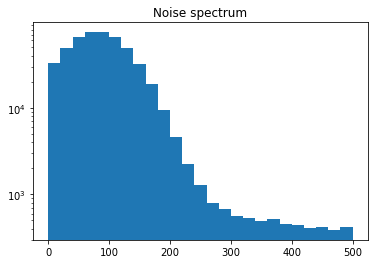

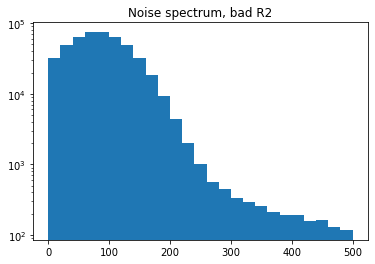

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


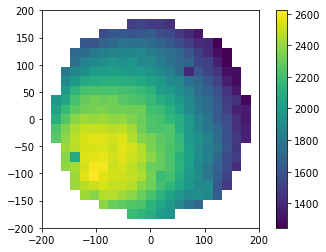

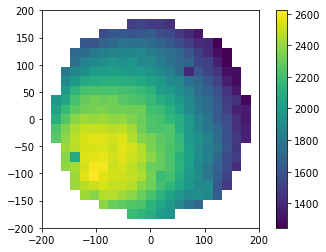

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 20.5
200000 / 584720
Est remaining = 16.1
300000 / 584720
Est remaining = 11.9
400000 / 584720
Est remaining = 7.6
500000 / 584720
Est remaining = 3.6


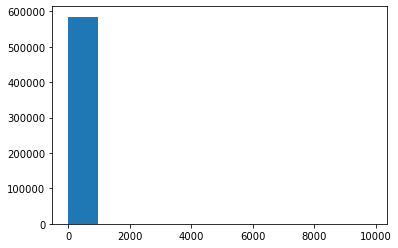

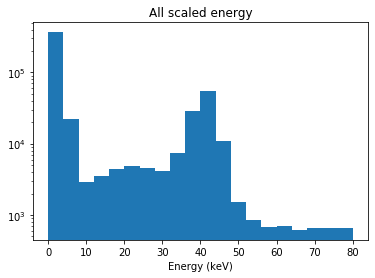

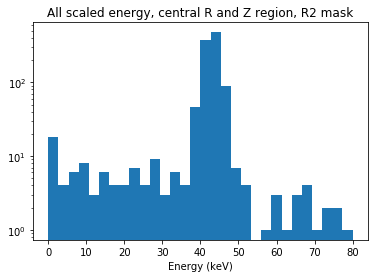

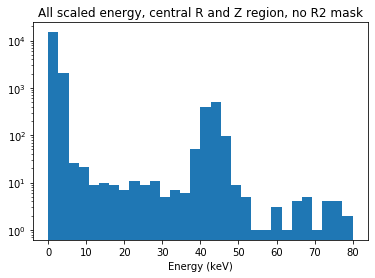

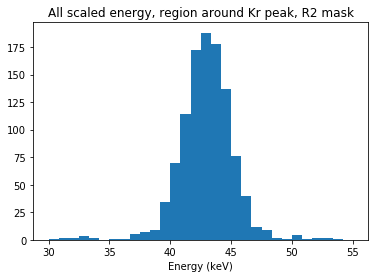

Correcting energies...
0 / 75540


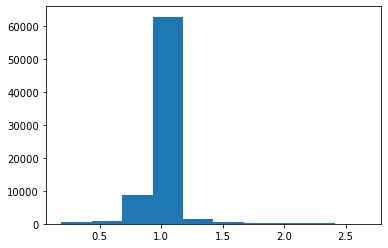

Fit a Gaussian with guess (A0, m0, s0) = (103.0, 1, 0.12201722015875498)


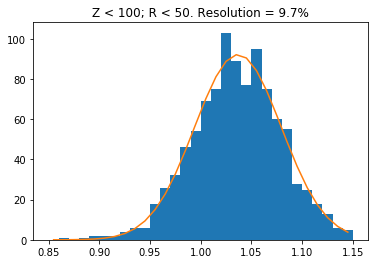

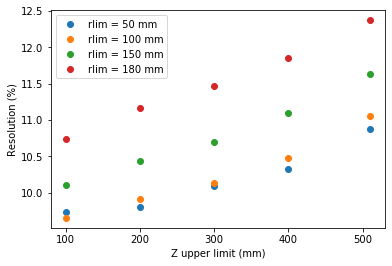

Innermost resolution =  9.74 %
Outermost resolution =  12.37 %
All resolutions: {100050: 9.740898618226472, 100100: 9.654801707998926, 100150: 10.105845264785284, 100180: 10.741375315865865, 200050: 9.810574790788237, 200100: 9.913067487163703, 200150: 10.436590941348715, 200180: 11.167196761827444, 300050: 10.098113537373033, 300100: 10.129592211797515, 300150: 10.701806571688454, 300180: 11.469288927422351, 400050: 10.332226463969462, 400100: 10.474295939669199, 400150: 11.090067259164478, 400180: 11.849958054100536, 510050: 10.878650727735382, 510100: 11.056324161082184, 510150: 11.630566071394824, 510180: 12.37079609643642}
Peak range = 498.0 , 3352.9
Selected percentage = 10.5 \%


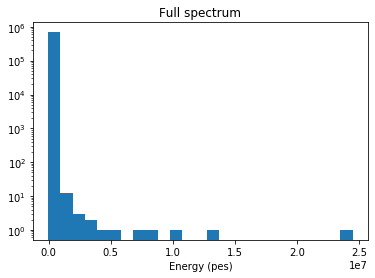

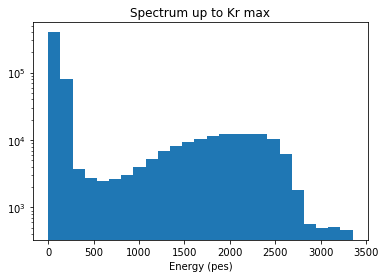

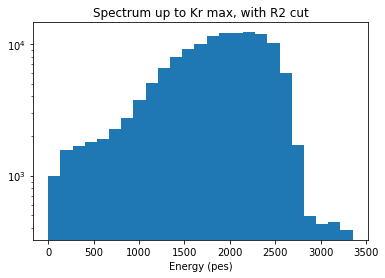

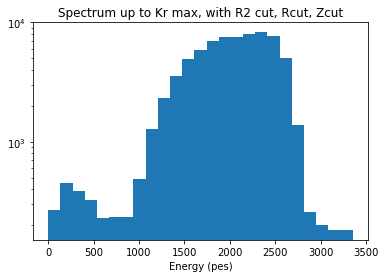

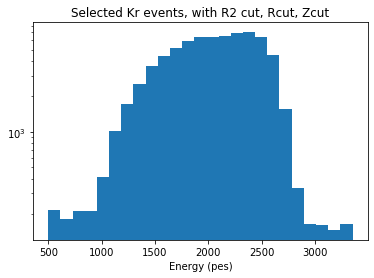

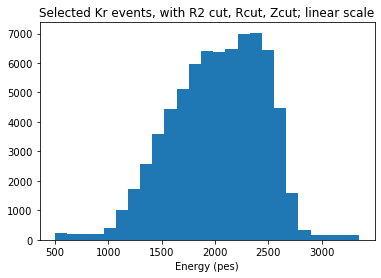

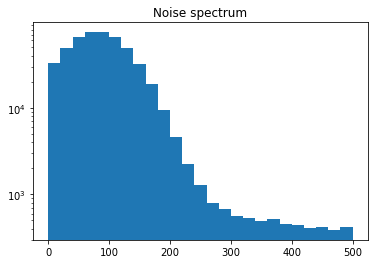

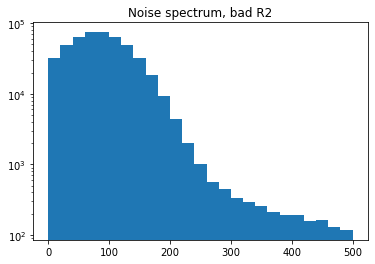

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


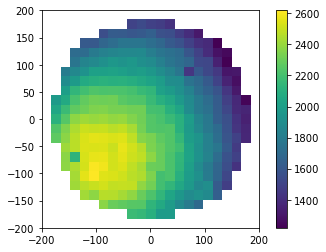

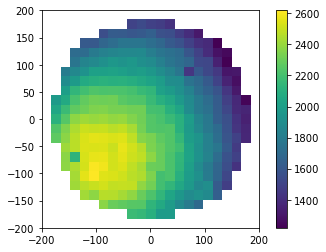

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 17.9
200000 / 584720
Est remaining = 15.8
300000 / 584720
Est remaining = 11.5
400000 / 584720
Est remaining = 7.4
500000 / 584720
Est remaining = 3.8


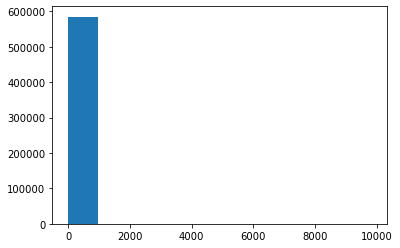

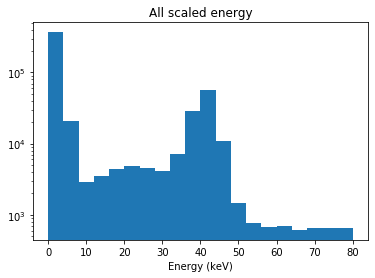

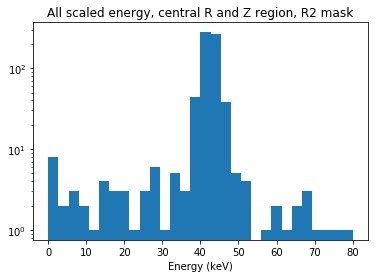

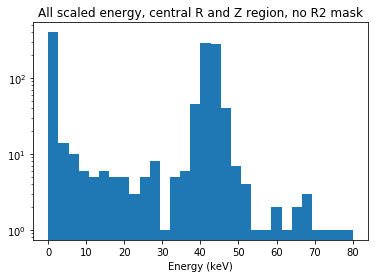

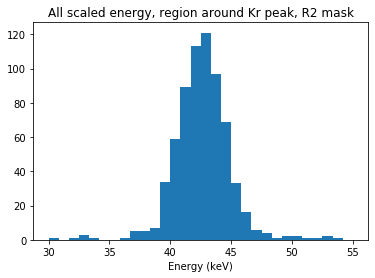

Correcting energies...
0 / 72389


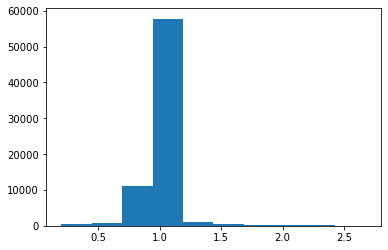

Fit a Gaussian with guess (A0, m0, s0) = (67.0, 1, 0.10818154535177459)


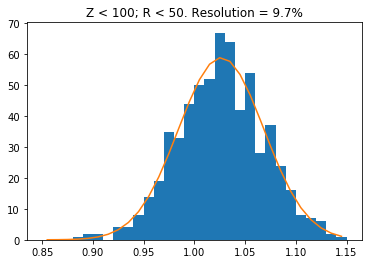

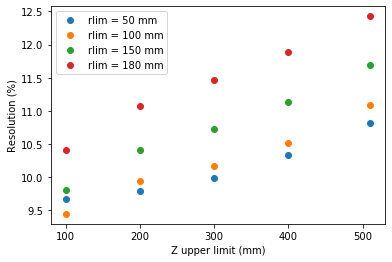

Innermost resolution =  9.67 %
Outermost resolution =  12.43 %
All resolutions: {100050: 9.671158107563159, 100100: 9.446404032359453, 100150: 9.802890665016898, 100180: 10.403730186852417, 200050: 9.795502811884388, 200100: 9.945206052557479, 200150: 10.408855909486858, 200180: 11.069727456770226, 300050: 9.988646079668774, 300100: 10.16362702640543, 300150: 10.725363267126776, 300180: 11.471951654474767, 400050: 10.328884568511876, 400100: 10.515195645301004, 400150: 11.134037692109622, 400180: 11.891710267287579, 510050: 10.811100923839016, 510100: 11.08614289356509, 510150: 11.693327201332465, 510180: 12.427563870941336}


In [23]:
try:
    res_gauss = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    res_rms = check_resolution(histat_Zrms, histat_events_energy_subtracted_pre, 0.9)
except:
    pass

In [24]:
try:
    print('Inner res for rms, gauss:')
    print(round(list(res_rms.values())[0], 2), ',', round(list(res_gauss.values())[0], 2))
    print('Outer res for rms, gauss:')
    print(round(list(res_rms.values())[-1], 2), ',', round(list(res_gauss.values())[-1], 2))
except:
    pass

Inner res for rms, gauss:
9.67 , 9.74
Outer res for rms, gauss:
12.43 , 12.37


Peak range = 472.1 , 3364.4
Selected percentage = 10.9 \%


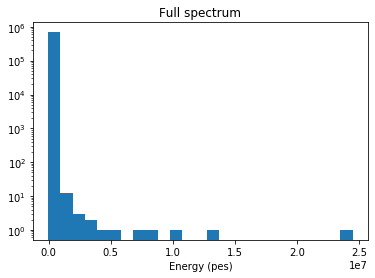

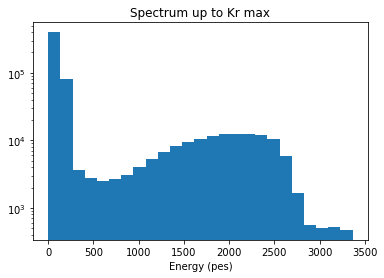

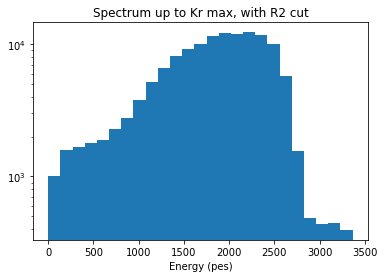

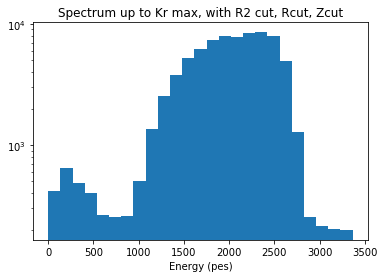

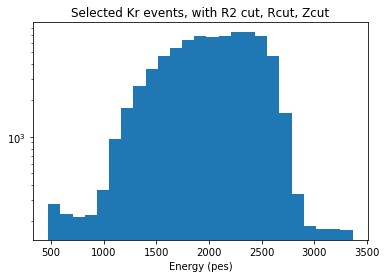

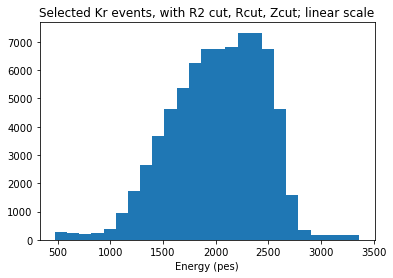

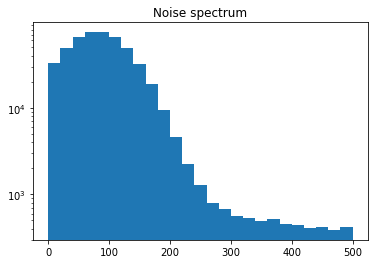

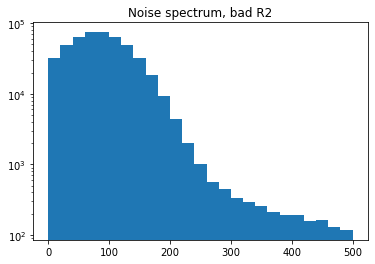

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


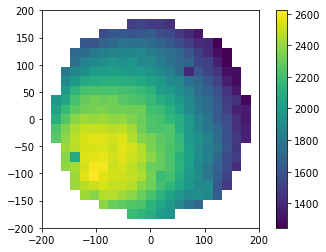

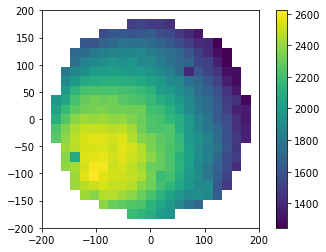

Correcting energies...
0 / 584720
100000 / 584720
Est remaining = 19.4
200000 / 584720
Est remaining = 17.7
300000 / 584720
Est remaining = 12.8
400000 / 584720
Est remaining = 8.2
500000 / 584720
Est remaining = 3.7


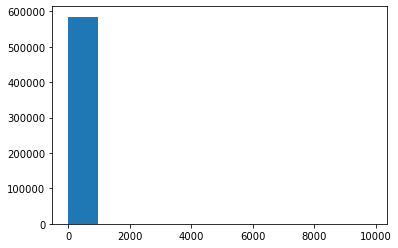

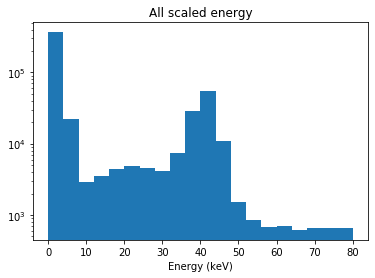

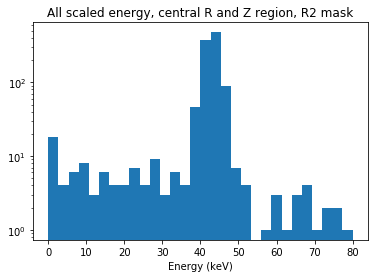

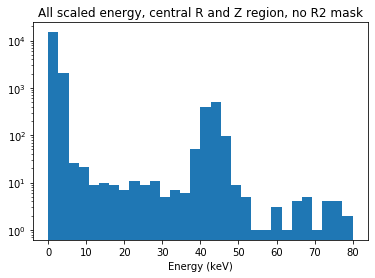

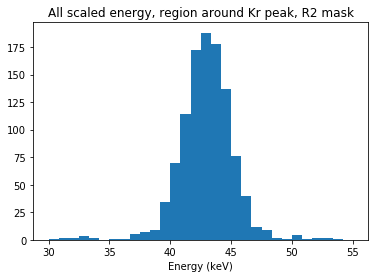

Correcting energies...
0 / 75540


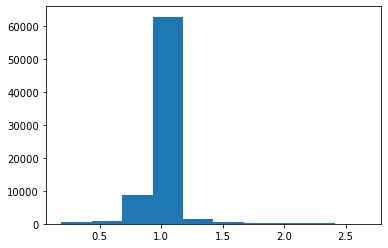

Fit a Gaussian with guess (A0, m0, s0) = (103.0, 1, 0.12201722015875498)


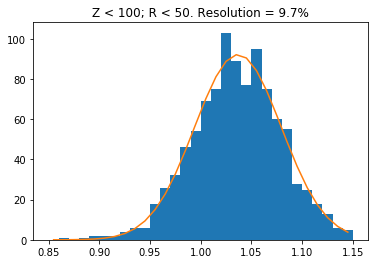

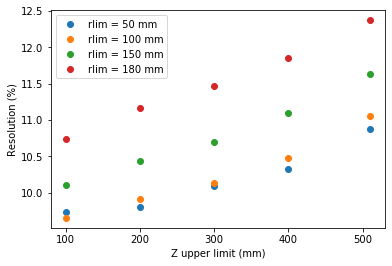

Innermost resolution =  9.74 %
Outermost resolution =  12.37 %
All resolutions: {100050: 9.740898618226472, 100100: 9.654801707998926, 100150: 10.105845264785284, 100180: 10.741375315865865, 200050: 9.810574790788237, 200100: 9.913067487163703, 200150: 10.436590941348715, 200180: 11.167196761827444, 300050: 10.098113537373033, 300100: 10.129592211797515, 300150: 10.701806571688454, 300180: 11.469288927422351, 400050: 10.332226463969462, 400100: 10.474295939669199, 400150: 11.090067259164478, 400180: 11.849958054100536, 510050: 10.878650727735382, 510100: 11.056324161082184, 510150: 11.630566071394824, 510180: 12.37079609643642}


{100050: 9.740898618226472,
 100100: 9.654801707998926,
 100150: 10.105845264785284,
 100180: 10.741375315865865,
 200050: 9.810574790788237,
 200100: 9.913067487163703,
 200150: 10.436590941348715,
 200180: 11.167196761827444,
 300050: 10.098113537373033,
 300100: 10.129592211797515,
 300150: 10.701806571688454,
 300180: 11.469288927422351,
 400050: 10.332226463969462,
 400100: 10.474295939669199,
 400150: 11.090067259164478,
 400180: 11.849958054100536,
 510050: 10.878650727735382,
 510100: 11.056324161082184,
 510150: 11.630566071394824,
 510180: 12.37079609643642}

In [25]:
# Output the proper map
check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)

In [26]:
print('Total time =',  round((time() - t0)/60,1), 'minutes')

Total time = 18.9 minutes
